In [168]:
import pandas as pd
from memo import memo
import jax
import jax.numpy as np
from enum import IntEnum, auto
# read in files
# Read UK_df.csv as pandas dataframe
original_UK_dialogue = pd.read_csv('UK_df.csv')
original_UK_politeness = pd.read_csv('UK_direct_df.csv')
original_UK_narrator = pd.read_csv('UK_narrator_df.csv')
original_US_dialogue = pd.read_csv('US_df.csv')
original_US_politeness = pd.read_csv('US_direct_df.csv')
original_US_narrator = pd.read_csv('US_narrator_df.csv')
dataframes = [original_UK_dialogue, original_UK_politeness, original_UK_narrator, original_US_dialogue, original_US_politeness, original_US_narrator]
def elim_outliers(df):
    # dropped Unnamed: 0 column
    df.drop(columns=['Unnamed: 0'], inplace=True)
    filtered_df = df.loc[(df['response'] > 95) | (df['response'] < 5)]
    for id in df['person_id'].unique():
        if len(filtered_df[filtered_df['person_id'] == id])/len(df[df['person_id'] == id])>0.8:
            df.drop(df[df['person_id'] == id].index, inplace=True)
    df['predicate Z-score'] = df.groupby(['person_id','predicate'])['response'].transform(lambda x: (x - x.mean()) / x.std())
    # if has_intensifier = no then change 'intensifier' to 'none'
    df.loc[df['has intensifier?'] == 'no', 'intensifier'] = 'none'
    return df
for i in range(len(dataframes)):
    dataframes[i] = elim_outliers(dataframes[i])
dialogue = pd.concat([dataframes[0], dataframes[3]])
politeness = pd.concat([dataframes[1], dataframes[4]])
UK_dialogue = dataframes[0]
US_dialogue = dataframes[3]
UK_politeness = dataframes[1]
US_politeness = dataframes[4]

# end of reading in data
#-------------------------------------------------------------------------------

# compute U_soc (social Utility)
U_soc_data = politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
UK_U_soc_data = UK_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
US_U_soc_data = US_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()

In [ ]:
# Create a list of JAX arrays
UK_measured_values = []
for p in P:
    for w in W:
        intensifier = w.name.replace('_'," ")
        predicate = p.name
        raw_values = UK_dialogue[((UK_dialogue['intensifier'] == intensifier) & (UK_dialogue['predicate'] == predicate))]['predicate Z-score'].values
        # measured_values.append(np.array([int(r/0.28)+10 for r in raw_values]))
        z = [int(r/0.28)+10 for r in raw_values]
        x = [0]*len(S)
        for i in z:
            x[i] += 1
        UK_measured_values.append(x)
UK_measured_values = np.array(UK_measured_values)

Define constants

In [169]:
epsilon = 0.01
infty = 10000000
S = np.arange(0,1,0.05)

Define params to iterate

In [170]:
class W(IntEnum):  # utterance space
    # intensifiers
    none = auto(0)
    slightly= auto()
    kind_of = auto()
    quite = auto()
    very= auto()
    extremely= auto()
class P(IntEnum):
    # predicates
    boring = auto(0)
    concerned = auto()
    difficult = auto()
    exhausted = auto()
    helpful = auto()
    impressive = auto()
    understandable = auto()
    

In [ ]:
def UK_soc_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    # compute fit e.g. log_likelihood
    for p in P:
        for w in W:
            intensifier = w.name.replace('_'," ")
            predicate = p.name
            raw_values = UK_dialogue[((UK_dialogue['intensifier'] == intensifier) & (UK_dialogue['predicate'] == predicate))]['predicate Z-score'].values
            # measured_values.append(np.array([int(r/0.28)+10 for r in raw_values]))
            z = [int(r/0.28)+10 for r in raw_values]
            x = [0]*len(S)
            for i in z:
                x[i] += 1
    P_l1 = np.concatenate([UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*UK_measured_values.T)

Construct measured_values which is an array of 42 arrays where the i'th entry is the values people reported for the i'th utterance

In [ ]:
@jax.jit
def state_prior(s):
    return np.exp(-(s-0.5)**2/60) # unlike perviously when s ranged from -2.8 to 2.8 now s-0.5 ranges from -0.5 to 0.5

@jax.jit
def UK_U_soc(intensifier,predicate):
    arr = np.array([
        [UK_U_soc_data[(w.name.replace('_'," "),p.name)] for p in P] 
        for w in W
    ])
    return arr[intensifier,predicate]
@jax.jit
def is_costly(w):
    arr = [0, 1, 1, 1, 1, 1]
    return np.array(arr)[w]
@jax.jit
def L(w, s,t0,t1,t2,t3,t4,t5):  # literal likelihood L(w | s)
    t = np.array([t0,t1,t2,t3,t4,t5])[w]
    sigt = 1 / (1 + np.exp(-t))
    return jax.lax.cond(
        sigt > s,
        lambda: epsilon,  # If condition (t > s) is True
        lambda: (1 - epsilon * sigt) / (1 - sigt)  # If condition is False
    )

@memo
def UKL1[s: S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5,p):
    listener: thinks[
        speaker: given(s in S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in S, wpp=L(w, s,t0,t1,t2,t3,t4,t5)) ,
                exp(inf_term * log(Pr[listener.s == s]) + 
                soc_term * UK_U_soc(w,p) - # U_soc = listener's EU
                cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]

In [ ]:
def UK_soc_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    # compute fit e.g. log_likelihood
    for p in P:
        for w in W:
            intensifier = w.name.replace('_'," ")
            predicate = p.name
            raw_values = UK_dialogue[((UK_dialogue['intensifier'] == intensifier) & (UK_dialogue['predicate'] == predicate))]['predicate Z-score'].values
            # measured_values.append(np.array([int(r/0.28)+10 for r in raw_values]))
            z = [int(r/0.28)+10 for r in raw_values]
            x = [0]*len(S)
            for i in z:
                x[i] += 1
    P_l1 = np.concatenate([UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*UK_measured_values.T)

initial beta (Array(0.18156481, dtype=float32), Array(-1.1198273, dtype=float32), Array(2.4091816, dtype=float32), Array(1.1899974, dtype=float32), Array(0.7083936, dtype=float32), Array(0.73111224, dtype=float32), Array(1.3064804, dtype=float32), Array(-1.7417994, dtype=float32), Array(-2.8596718, dtype=float32))
-4901.3394 4 (Array(-1.0184352, dtype=float32), Array(-0.47762093, dtype=float32), Array(1.3857687, dtype=float32), Array(-0.01000261, dtype=float32), Array(-0.49160647, dtype=float32), Array(-0.4688878, dtype=float32), Array(2.5064802, dtype=float32), Array(-0.5417994, dtype=float32), Array(-2.8597984, dtype=float32))
-4508.8843 5 (Array(-1.1556244, dtype=float32), Array(-0.26398486, dtype=float32), Array(1.0857687, dtype=float32), Array(-0.11561469, dtype=float32), Array(-0.59435785, dtype=float32), Array(-0.5569165, dtype=float32), Array(2.8064802, dtype=float32), Array(-0.24179941, dtype=float32), Array(-3.0340238, dtype=float32))
-4493.8584 6 (Array(-1.1892902, dtype=flo

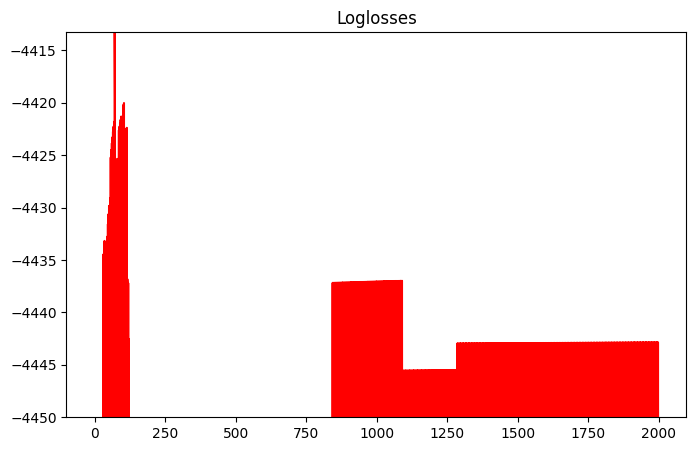

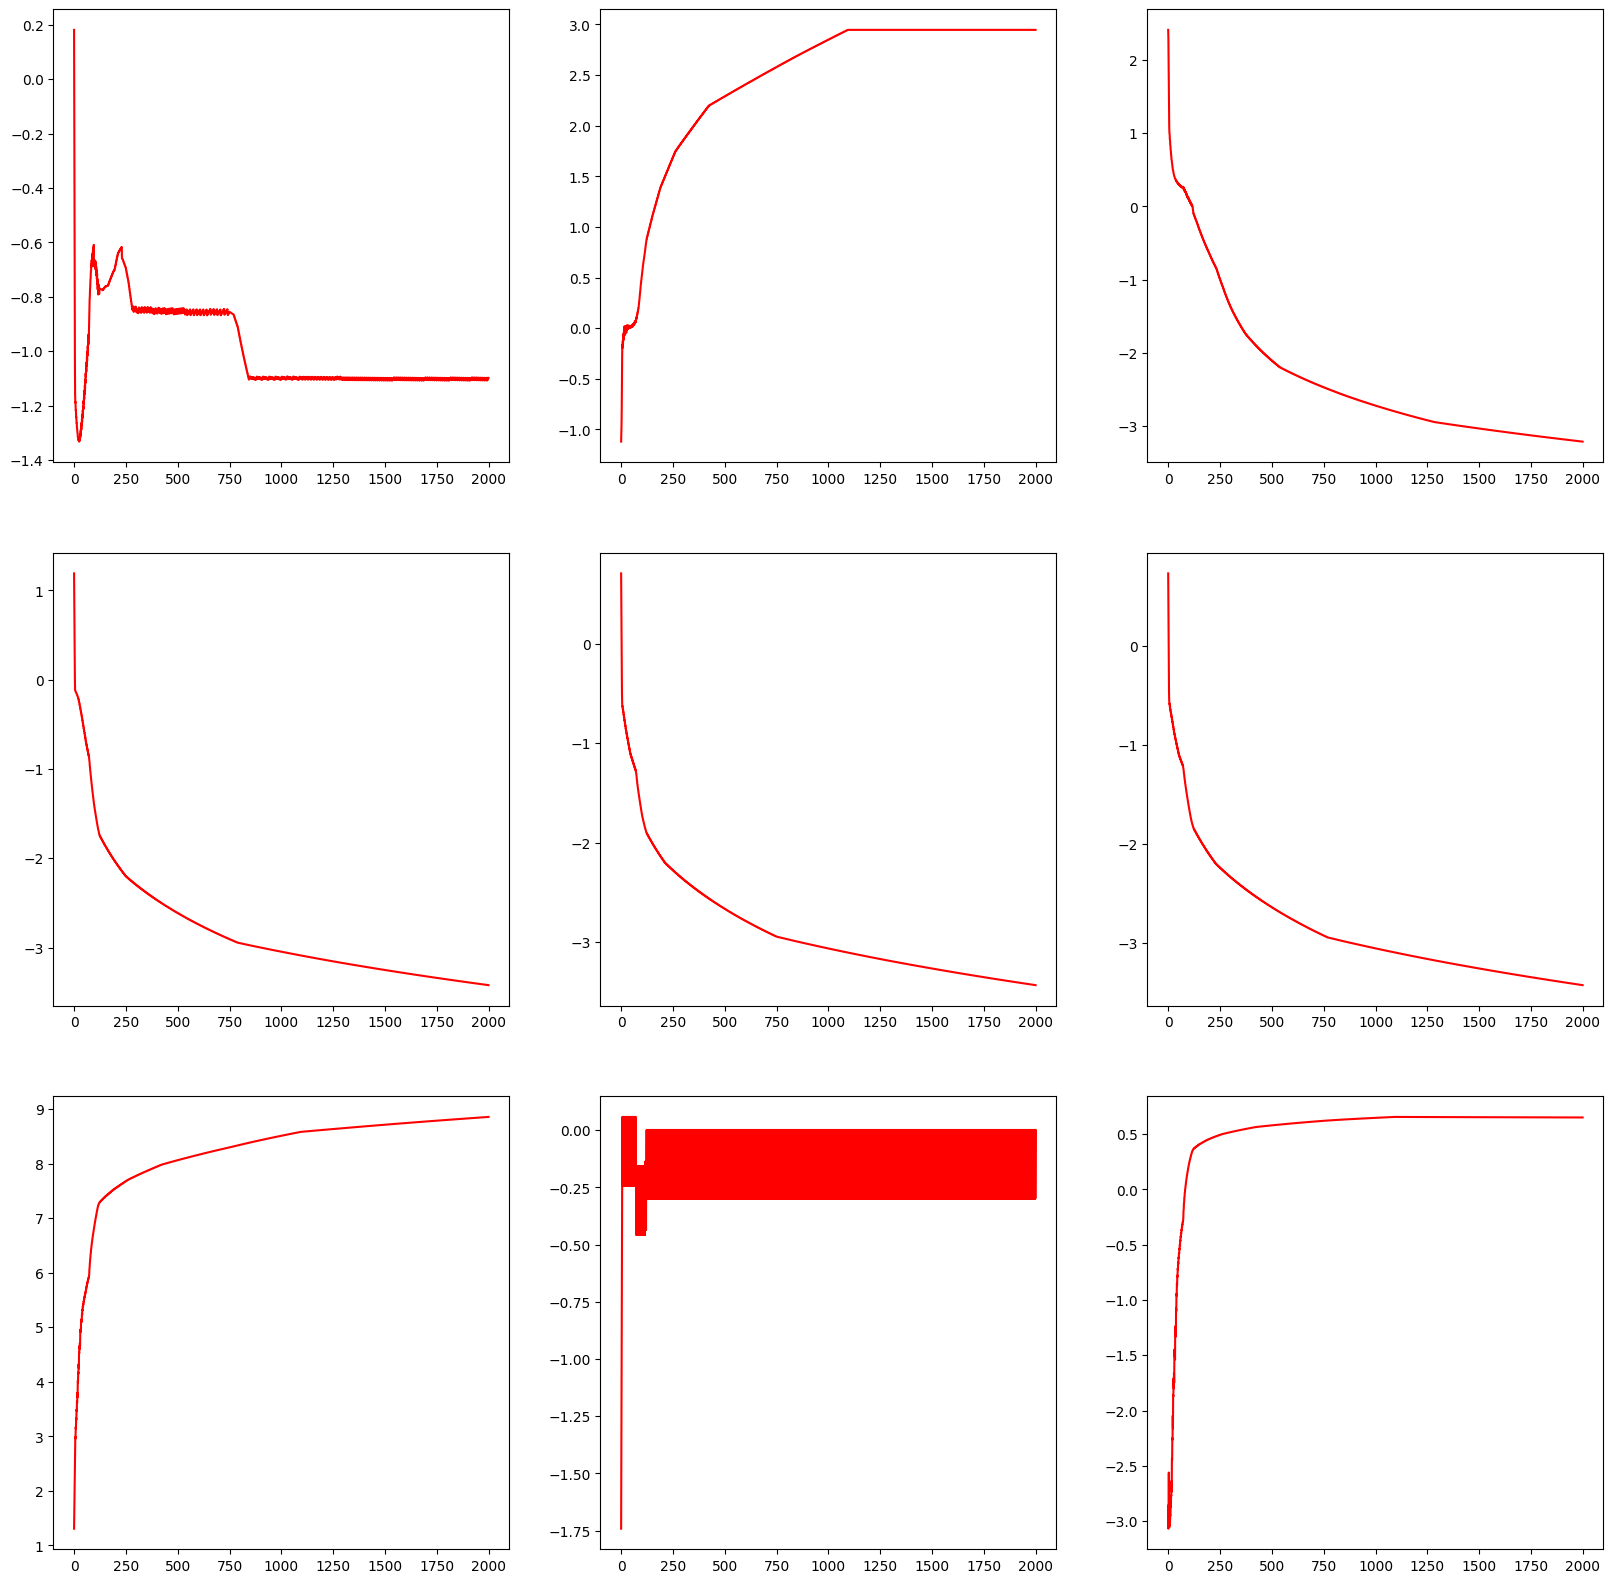

initial beta (Array(1.3659854, dtype=float32), Array(1.7272053, dtype=float32), Array(-1.9098344, dtype=float32), Array(-1.4242187, dtype=float32), Array(-2.335624, dtype=float32), Array(-1.7842155, dtype=float32), Array(-1.0938692, dtype=float32), Array(-2.366578, dtype=float32), Array(-0.42096233, dtype=float32))
-4699.209 7 (Array(-0.73401463, dtype=float32), Array(0.08956981, dtype=float32), Array(-1.9246963, dtype=float32), Array(-1.543301, dtype=float32), Array(-2.3818119, dtype=float32), Array(-1.8812209, dtype=float32), Array(-1.7068946, dtype=float32), Array(-0.26657826, dtype=float32), Array(1.0790377, dtype=float32))
-4465.3184 8 (Array(-0.94972575, dtype=float32), Array(0.0648919, dtype=float32), Array(-1.9207945, dtype=float32), Array(-1.5342416, dtype=float32), Array(-2.3794088, dtype=float32), Array(-1.8757751, dtype=float32), Array(-1.5573825, dtype=float32), Array(0.03342175, dtype=float32), Array(1.1137527, dtype=float32))
-4462.3657 24 (Array(-0.2589724, dtype=float3

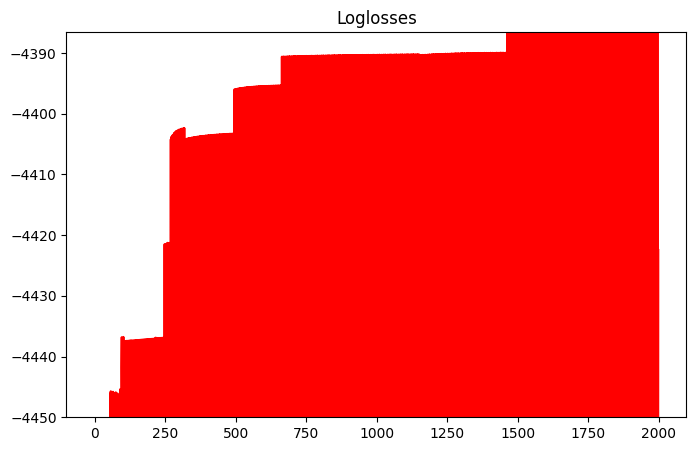

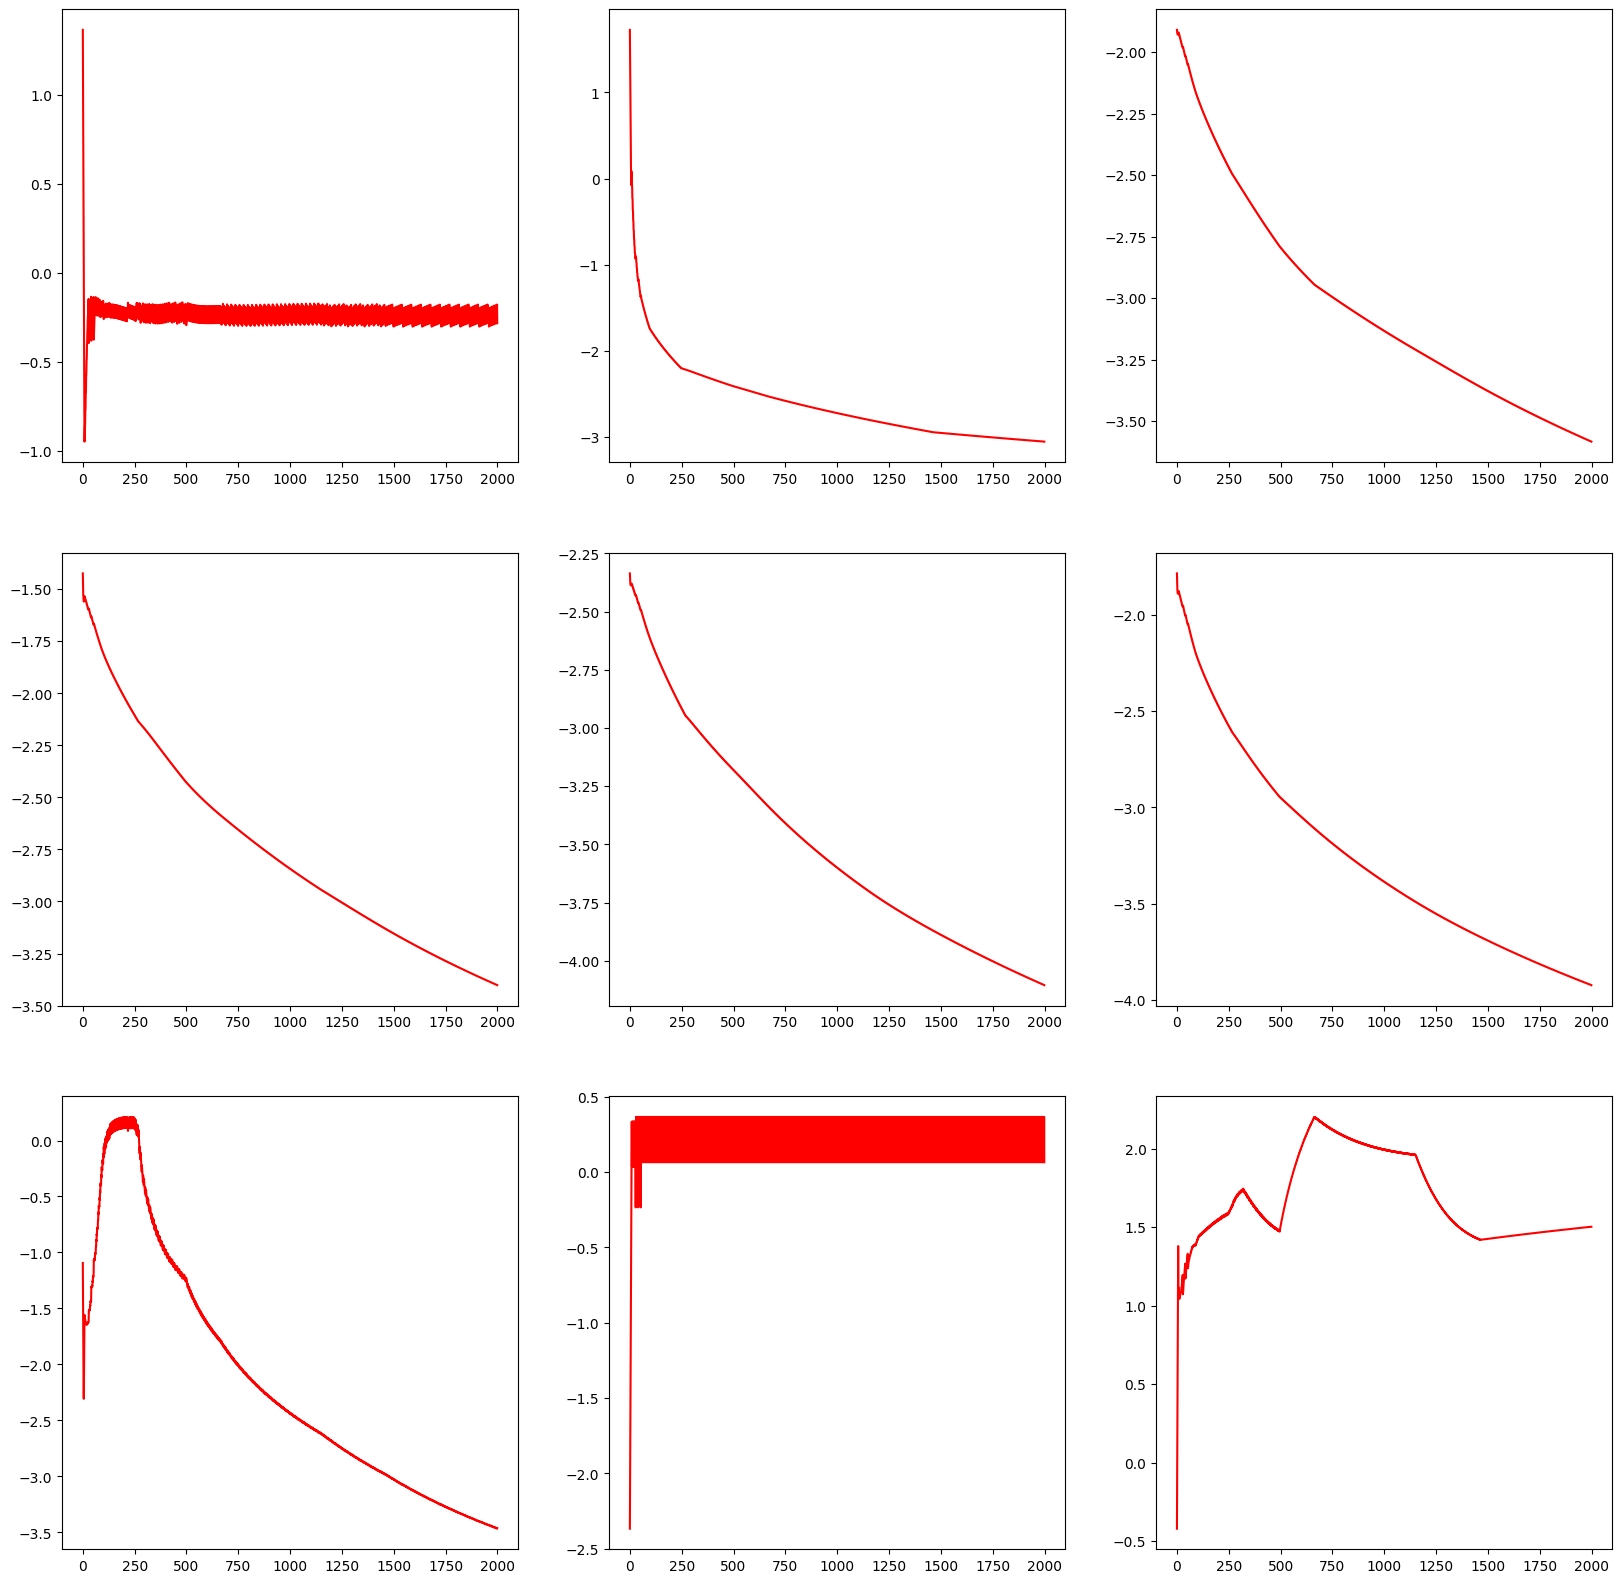

initial beta (Array(1.0034437, dtype=float32), Array(1.3289201, dtype=float32), Array(-2.2392318, dtype=float32), Array(-0.8743386, dtype=float32), Array(-0.47345066, dtype=float32), Array(-2.7475562, dtype=float32), Array(-2.7996047, dtype=float32), Array(-1.0670757, dtype=float32), Array(-0.07647657, dtype=float32))
-4898.718 1 (Array(0.96459854, dtype=float32), Array(1.0289202, dtype=float32), Array(-2.2412164, dtype=float32), Array(-0.9253189, dtype=float32), Array(-0.68481123, dtype=float32), Array(-2.7529042, dtype=float32), Array(-2.9693248, dtype=float32), Array(-0.7670757, dtype=float32), Array(0.22352344, dtype=float32))
-4414.383 2 (Array(0.98610294, dtype=float32), Array(0.72892016, dtype=float32), Array(-2.2415164, dtype=float32), Array(-0.95508844, dtype=float32), Array(-0.75312036, dtype=float32), Array(-2.754979, dtype=float32), Array(-3.132077, dtype=float32), Array(-0.4670757, dtype=float32), Array(0.52352345, dtype=float32))
-4291.7456 3 (Array(1.0647817, dtype=float

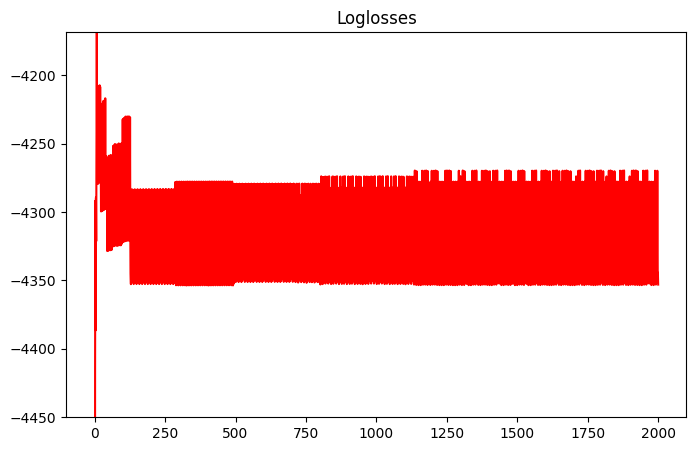

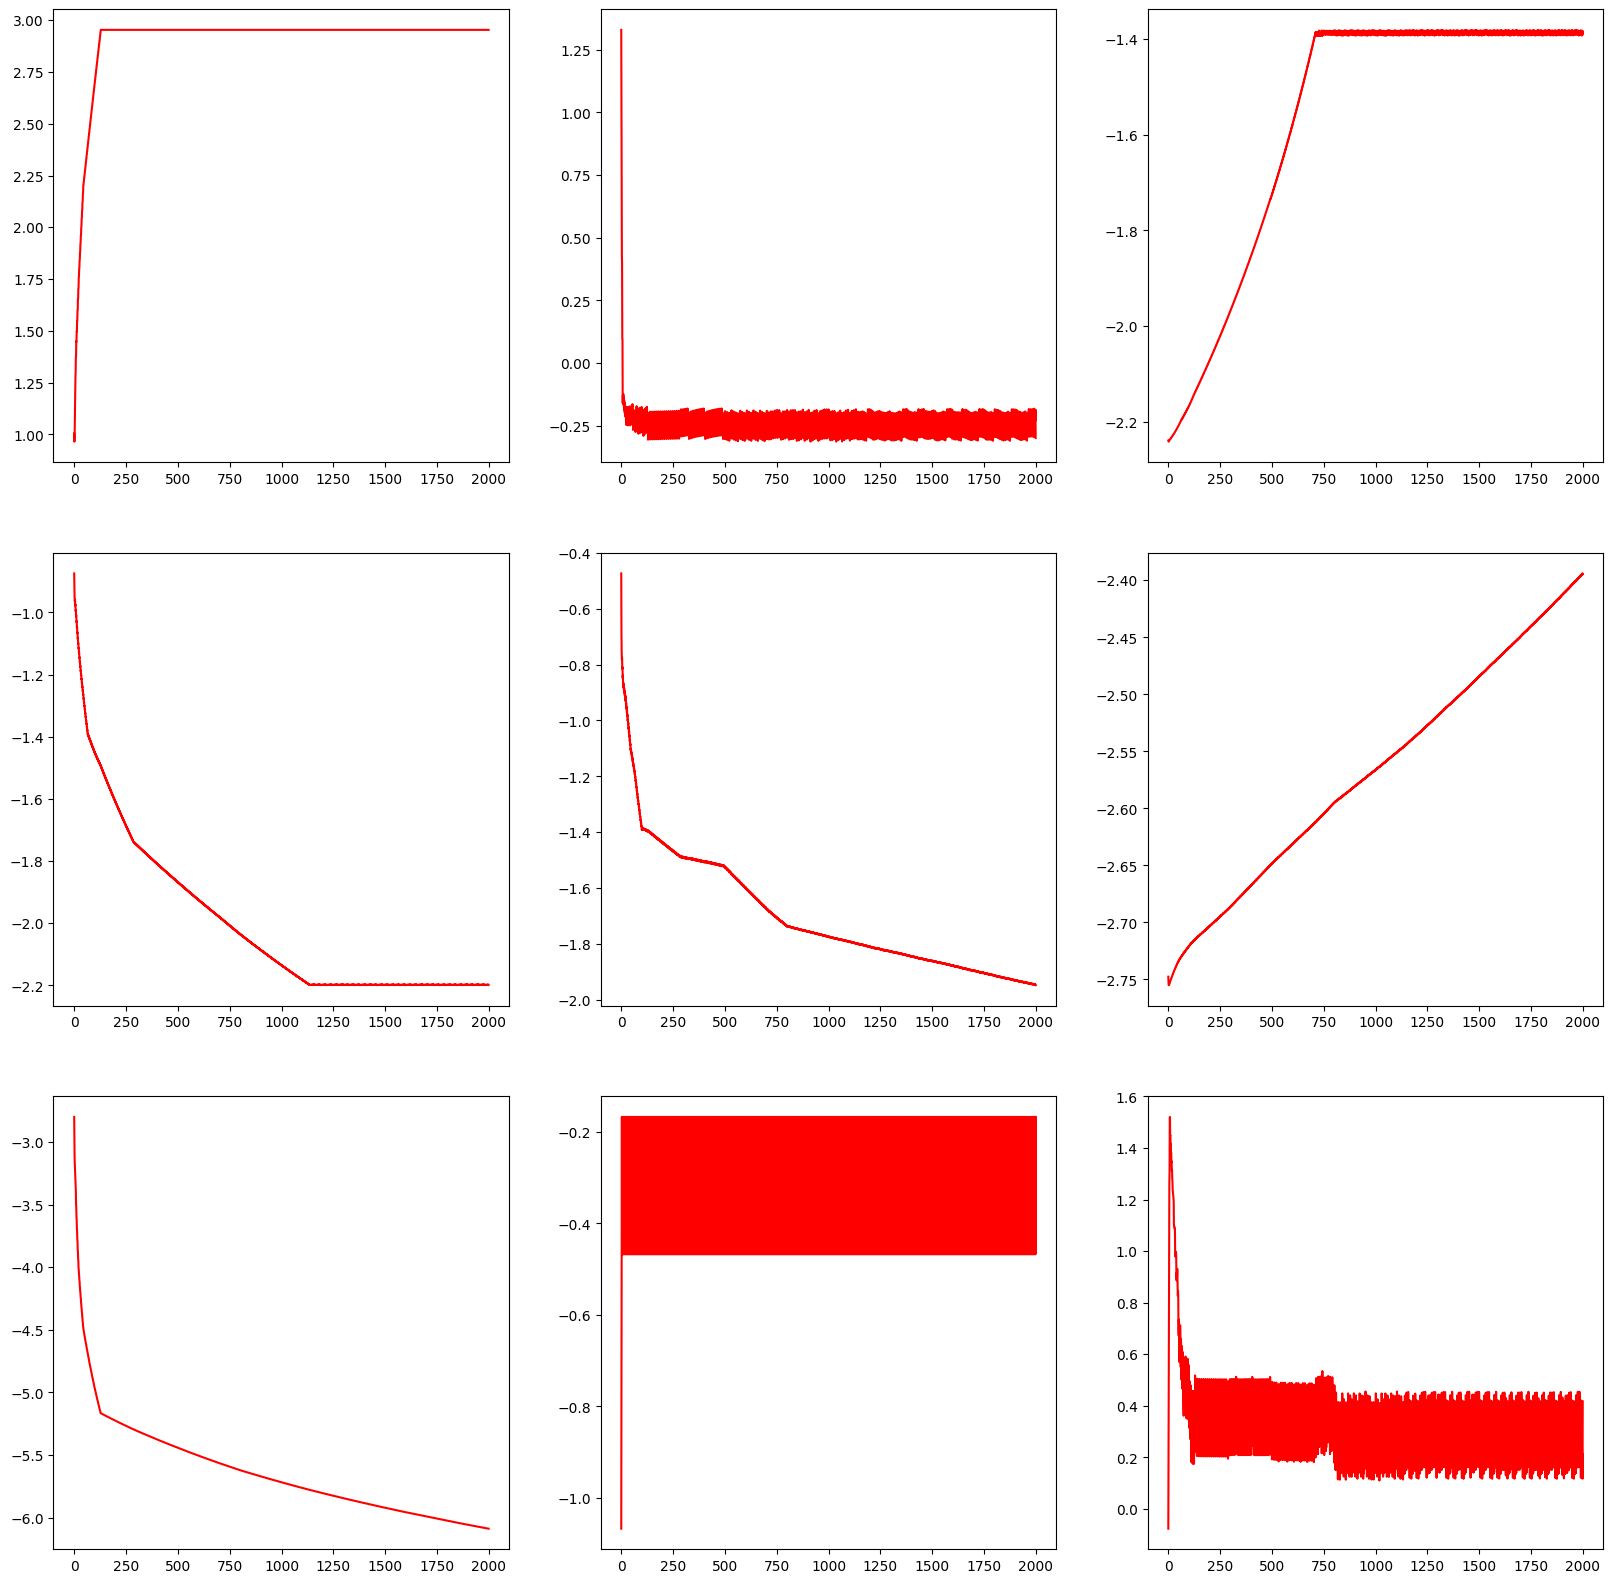

initial beta (Array(-0.6659274, dtype=float32), Array(-2.4855838, dtype=float32), Array(-2.693877, dtype=float32), Array(0.730314, dtype=float32), Array(-0.8981638, dtype=float32), Array(0.48266816, dtype=float32), Array(0.39839745, dtype=float32), Array(-1.8551159, dtype=float32), Array(0.14399028, dtype=float32))
-4810.467 4 (Array(-1.6740204, dtype=float32), Array(-2.4576116, dtype=float32), Array(-2.6769762, dtype=float32), Array(-0.46968603, dtype=float32), Array(-1.0308143, dtype=float32), Array(-0.6969598, dtype=float32), Array(1.5983975, dtype=float32), Array(-0.65511596, dtype=float32), Array(-0.45600975, dtype=float32))
-4582.996 5 (Array(-1.7096074, dtype=float32), Array(-2.4552586, dtype=float32), Array(-2.6765568, dtype=float32), Array(-0.6006531, dtype=float32), Array(-1.0821975, dtype=float32), Array(-0.77132046, dtype=float32), Array(1.7896761, dtype=float32), Array(-0.35511595, dtype=float32), Array(-0.15600973, dtype=float32))
-4482.4053 6 (Array(-1.7175003, dtype=flo

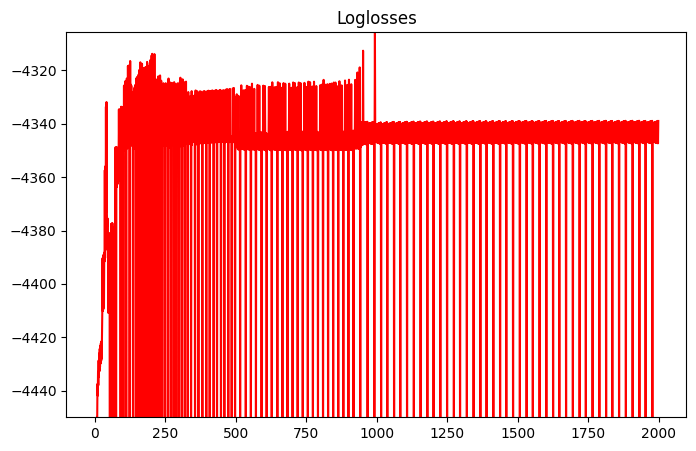

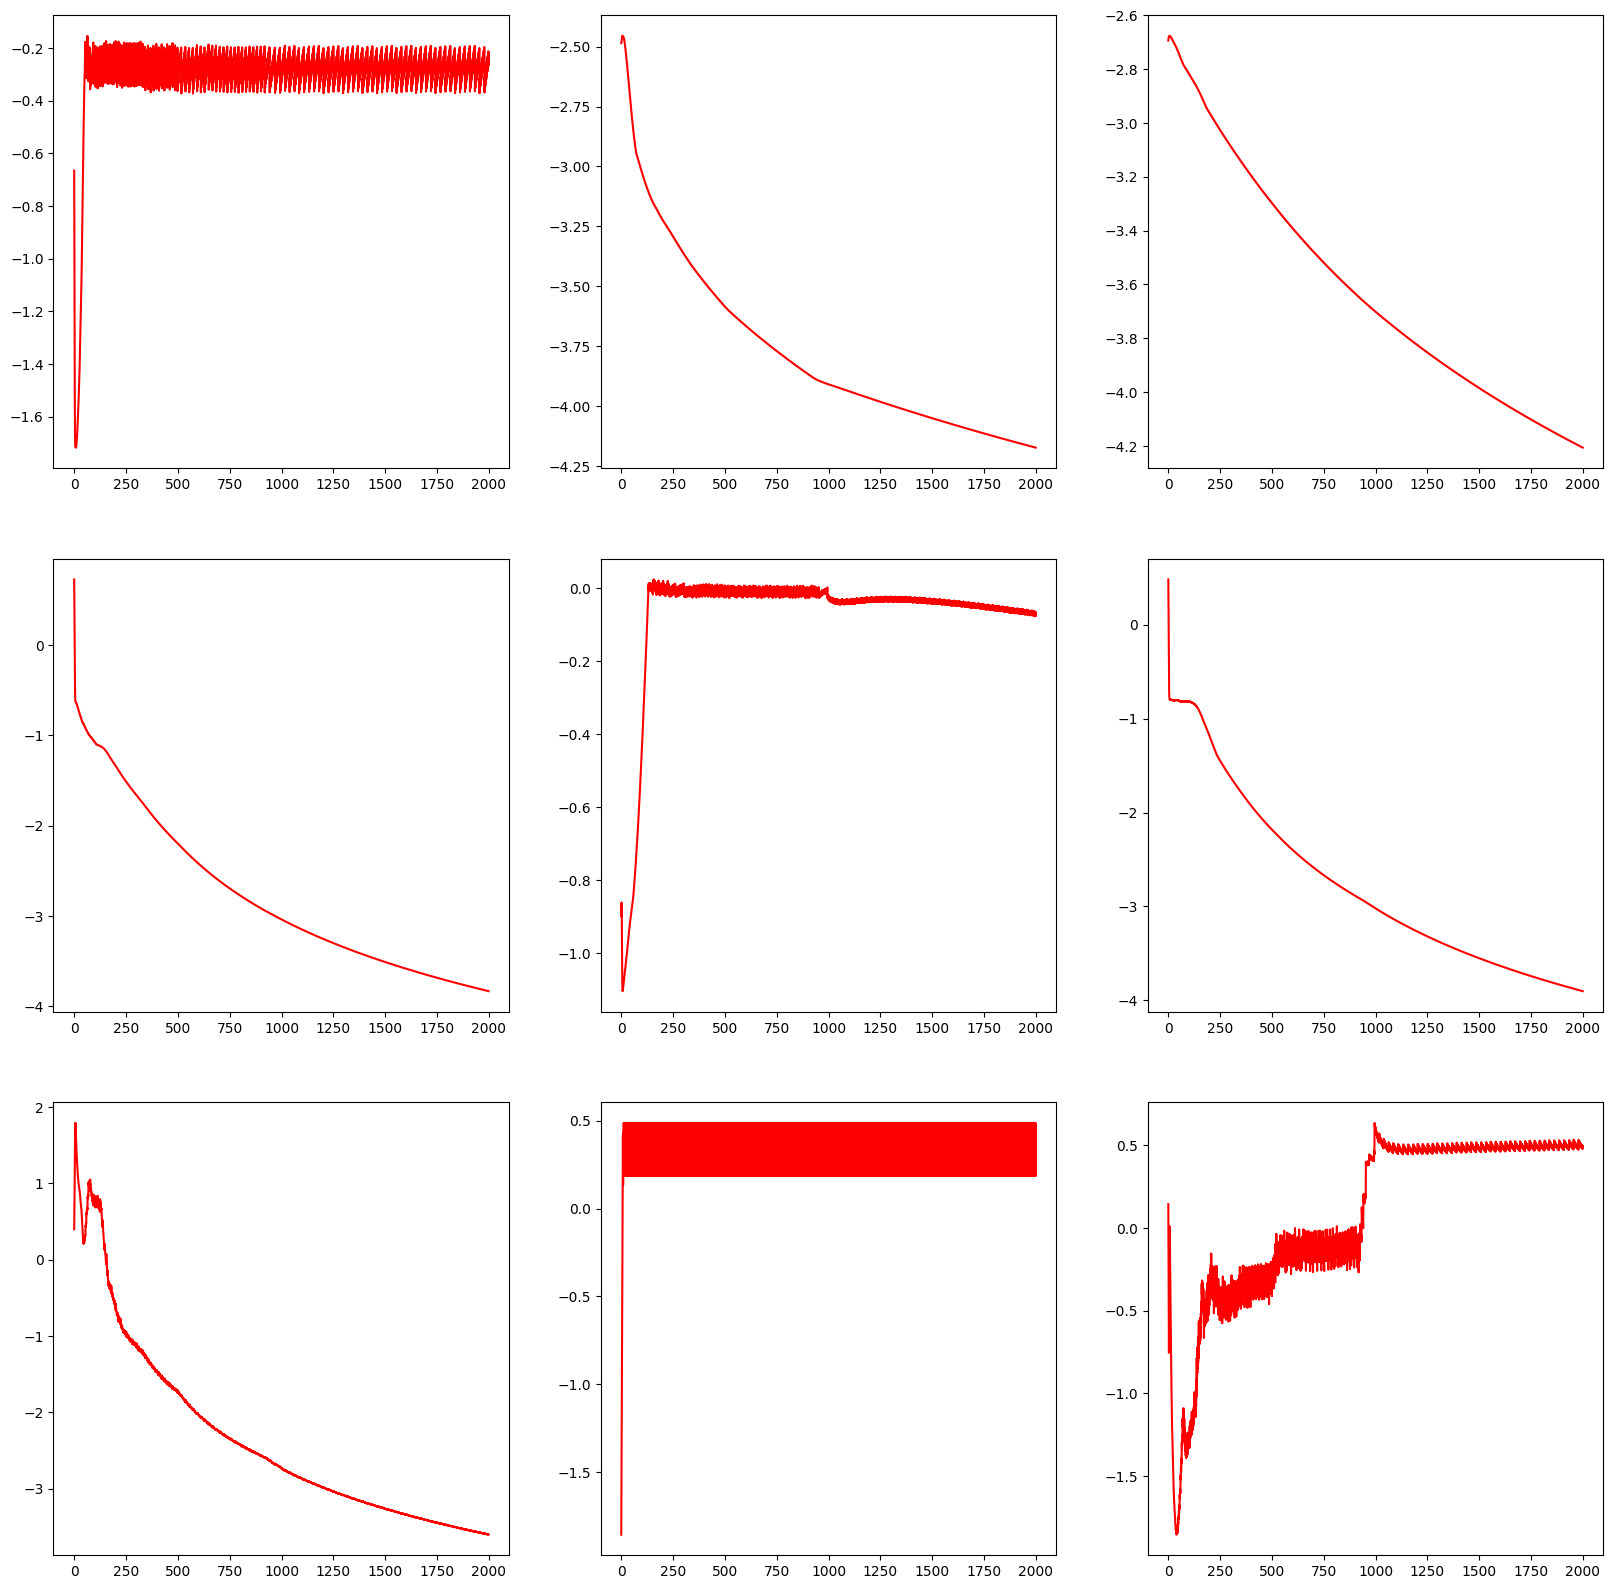

initial beta (Array(1.4624376, dtype=float32), Array(0.4131117, dtype=float32), Array(2.6724272, dtype=float32), Array(1.6815548, dtype=float32), Array(1.6439102, dtype=float32), Array(0.63892365, dtype=float32), Array(0.81729054, dtype=float32), Array(-0.29713225, dtype=float32), Array(2.948739, dtype=float32))
-4553.782 0 (Array(1.4624376, dtype=float32), Array(0.4131117, dtype=float32), Array(2.6724272, dtype=float32), Array(1.6815548, dtype=float32), Array(1.6439102, dtype=float32), Array(0.63892365, dtype=float32), Array(0.81729054, dtype=float32), Array(-0.29713225, dtype=float32), Array(2.948739, dtype=float32))
-4471.9805 1 (Array(1.5423886, dtype=float32), Array(0.41572163, dtype=float32), Array(2.7371354, dtype=float32), Array(1.6684202, dtype=float32), Array(1.5795798, dtype=float32), Array(0.49271104, dtype=float32), Array(0.8308039, dtype=float32), Array(0.00286776, dtype=float32), Array(2.8486054, dtype=float32))
-4468.4185 10 (Array(1.0659442, dtype=float32), Array(0.198

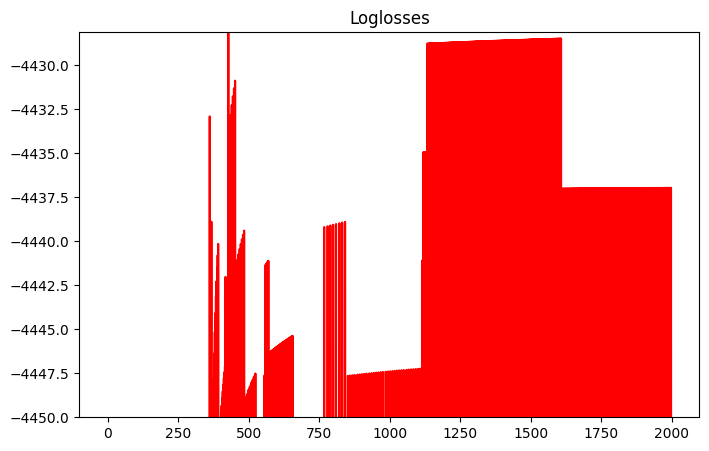

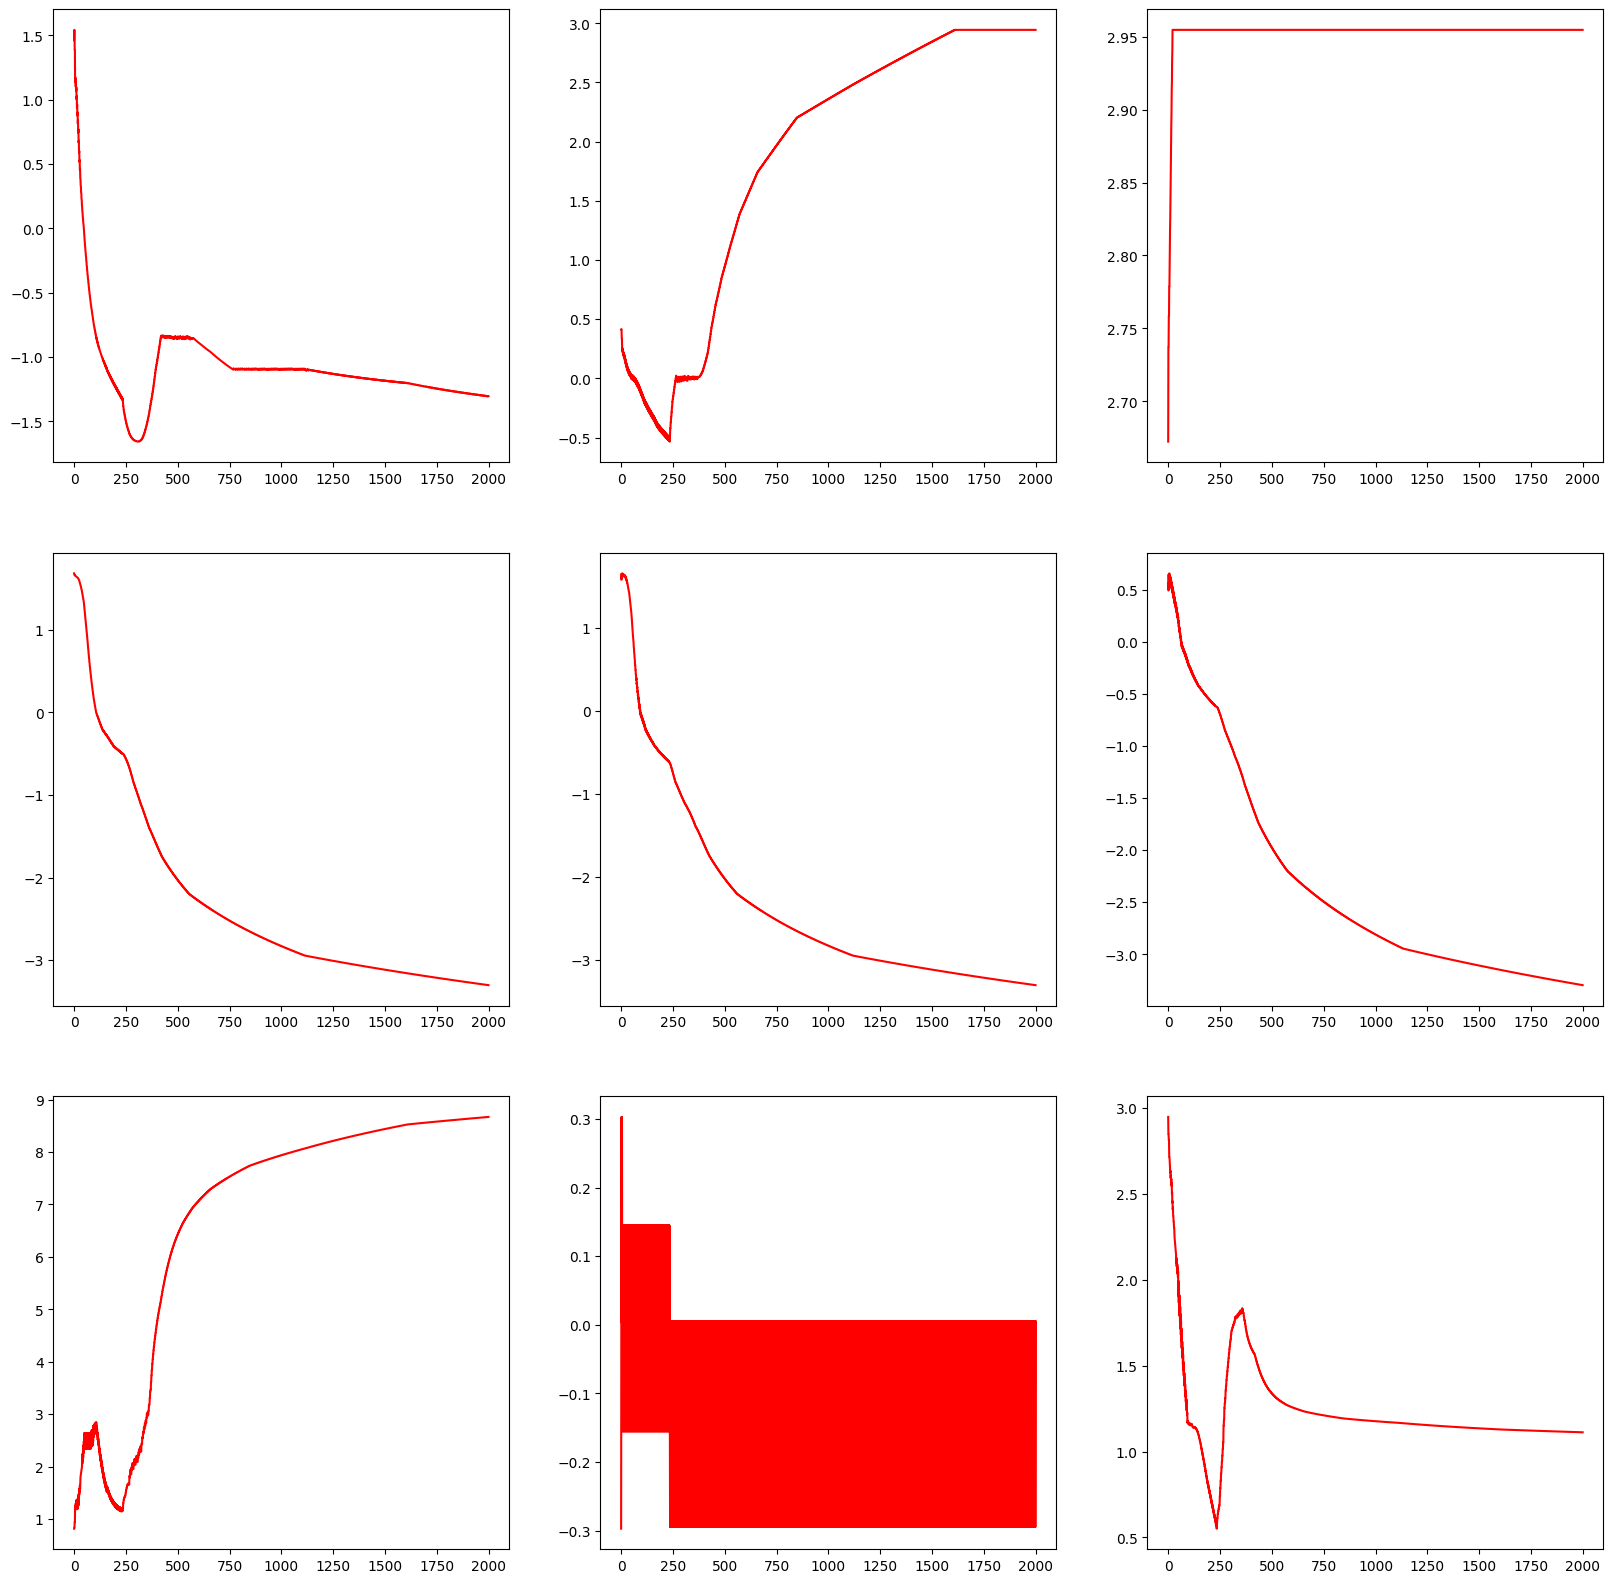

initial beta (Array(-0.5144427, dtype=float32), Array(-2.8594995, dtype=float32), Array(-1.3756113, dtype=float32), Array(-1.9078453, dtype=float32), Array(2.6067688, dtype=float32), Array(-0.24102974, dtype=float32), Array(-1.416652, dtype=float32), Array(0.2280972, dtype=float32), Array(-0.3209195, dtype=float32))
-4387.017 0 (Array(-0.5144427, dtype=float32), Array(-2.8594995, dtype=float32), Array(-1.3756113, dtype=float32), Array(-1.9078453, dtype=float32), Array(2.6067688, dtype=float32), Array(-0.24102974, dtype=float32), Array(-1.416652, dtype=float32), Array(0.2280972, dtype=float32), Array(-0.3209195, dtype=float32))
-4326.632 31 (Array(-0.2358318, dtype=float32), Array(-2.899031, dtype=float32), Array(-1.5782024, dtype=float32), Array(-2.017808, dtype=float32), Array(0.46778473, dtype=float32), Array(-0.52108043, dtype=float32), Array(-1.6560918, dtype=float32), Array(0.33106977, dtype=float32), Array(1.3559068, dtype=float32))
-4315.0913 43 (Array(-0.24000433, dtype=float32

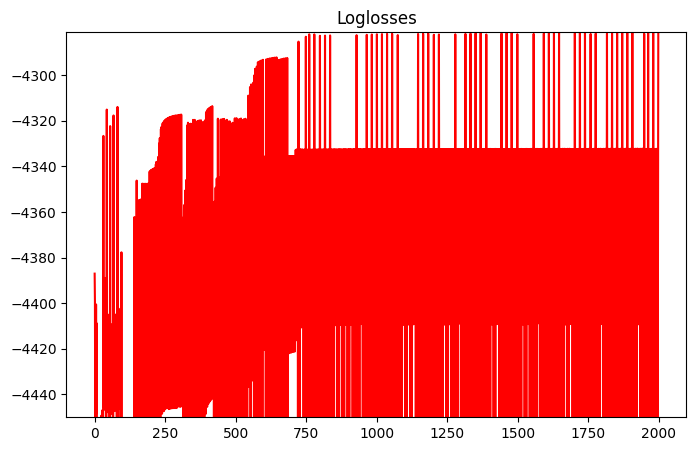

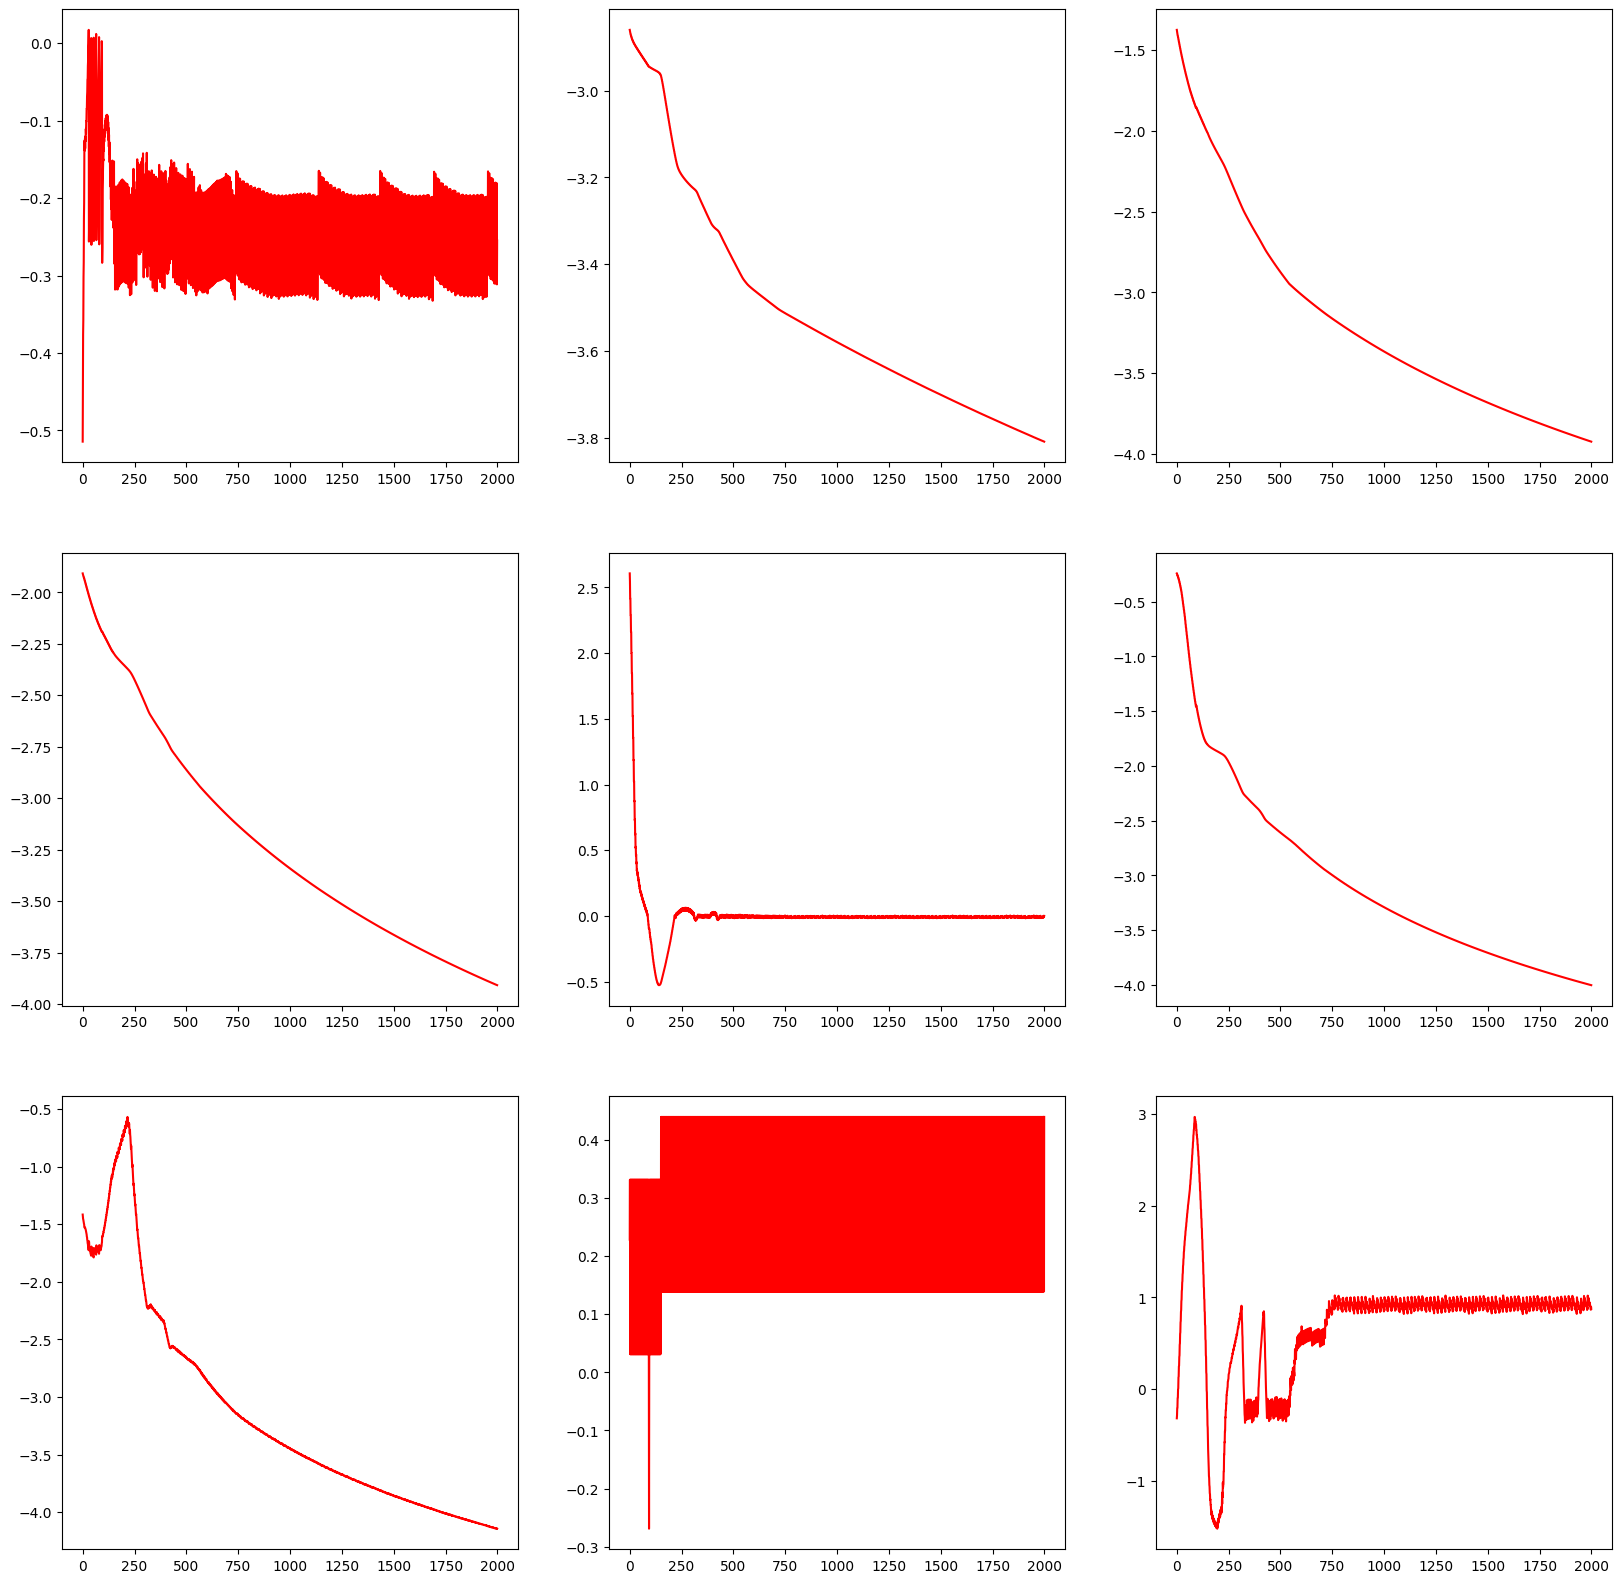

initial beta (Array(-0.6024492, dtype=float32), Array(-1.4307382, dtype=float32), Array(-1.5203819, dtype=float32), Array(0.13433218, dtype=float32), Array(0.65725136, dtype=float32), Array(2.5312507, dtype=float32), Array(0.9270437, dtype=float32), Array(2.6147168, dtype=float32), Array(-1.47207, dtype=float32))
-4882.006 5 (Array(-0.46719757, dtype=float32), Array(-2.1473472, dtype=float32), Array(-1.7214096, dtype=float32), Array(-0.9385417, dtype=float32), Array(-0.37805232, dtype=float32), Array(1.031251, dtype=float32), Array(-0.15680563, dtype=float32), Array(1.114717, dtype=float32), Array(0.02793002, dtype=float32))
-4516.6396 6 (Array(-0.4421047, dtype=float32), Array(-2.179201, dtype=float32), Array(-1.7534466, dtype=float32), Array(-0.99710304, dtype=float32), Array(-0.4445737, dtype=float32), Array(0.73125094, dtype=float32), Array(-0.27273577, dtype=float32), Array(0.814717, dtype=float32), Array(0.32793003, dtype=float32))
-4295.1284 7 (Array(-0.39075732, dtype=float32),

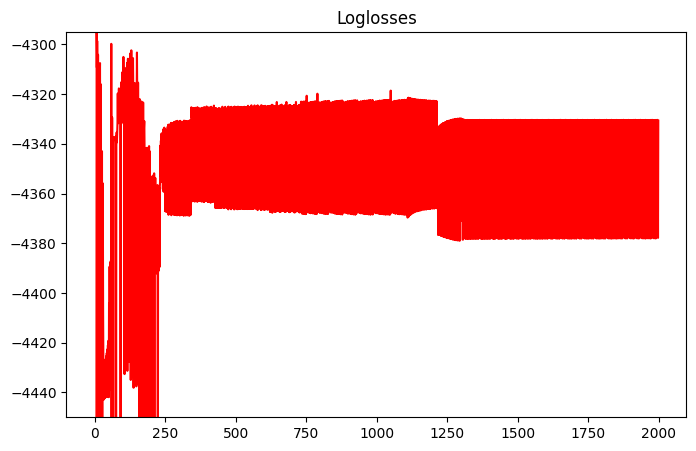

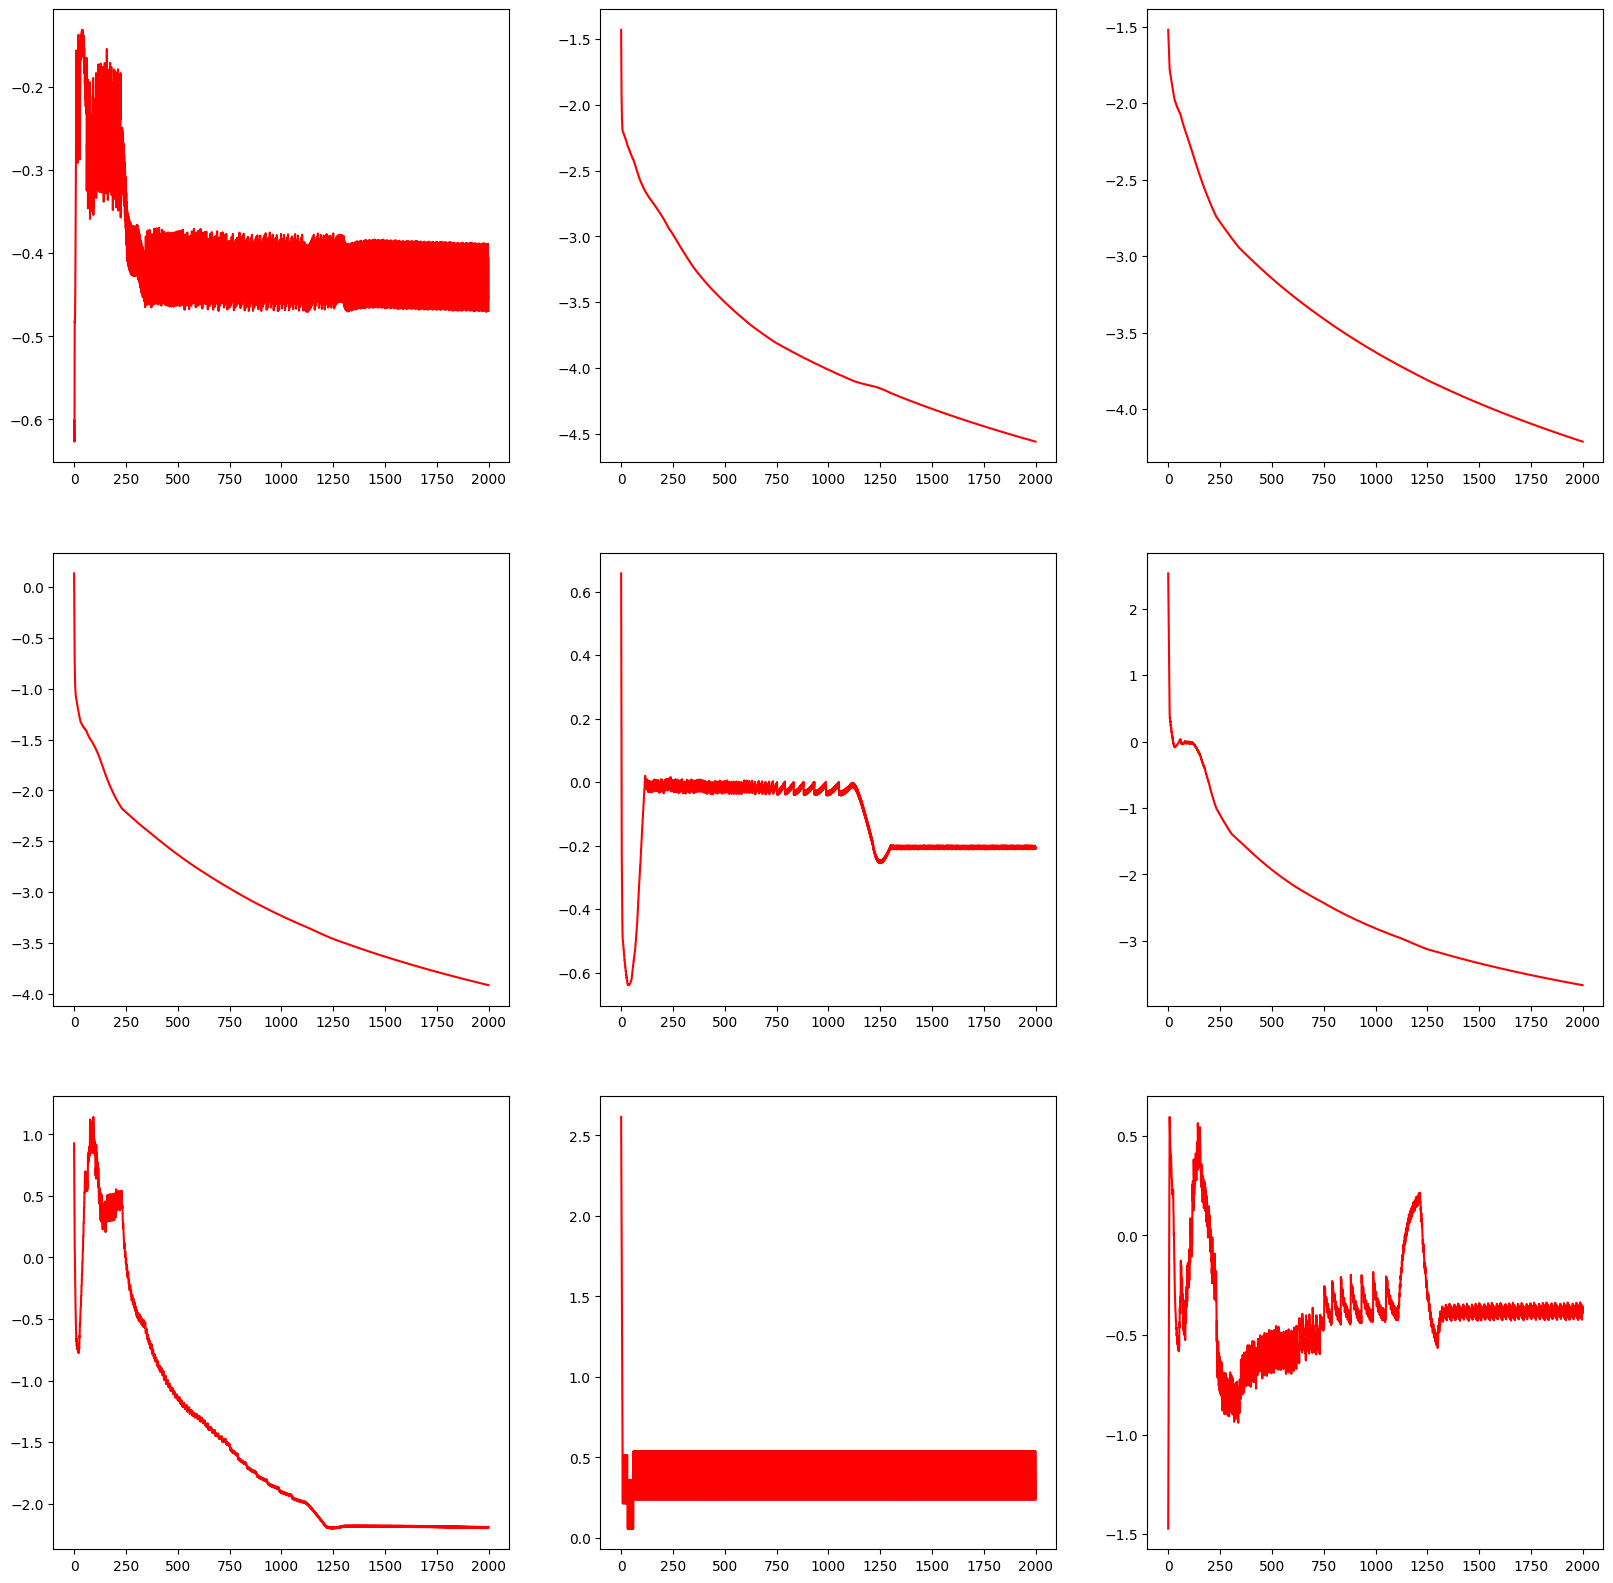

initial beta (Array(0.68142843, dtype=float32), Array(-0.0230577, dtype=float32), Array(0.36407018, dtype=float32), Array(0.7165854, dtype=float32), Array(0.1135397, dtype=float32), Array(0.10443735, dtype=float32), Array(-2.5800562, dtype=float32), Array(2.0703228, dtype=float32), Array(-2.399213, dtype=float32))
-4506.703 5 (Array(-0.2185716, dtype=float32), Array(-1.4786305, dtype=float32), Array(-0.84746915, dtype=float32), Array(-0.5994878, dtype=float32), Array(-0.01989077, dtype=float32), Array(-0.11221552, dtype=float32), Array(-2.3712127, dtype=float32), Array(0.5703229, dtype=float32), Array(-1.4774764, dtype=float32))
-4454.4688 6 (Array(-0.07064597, dtype=float32), Array(-1.5820951, dtype=float32), Array(-0.89347416, dtype=float32), Array(-0.66584444, dtype=float32), Array(-0.02128254, dtype=float32), Array(-0.12993199, dtype=float32), Array(-2.3580287, dtype=float32), Array(0.27032286, dtype=float32), Array(-1.2757754, dtype=float32))
-4451.8154 8 (Array(-0.02142231, dtype

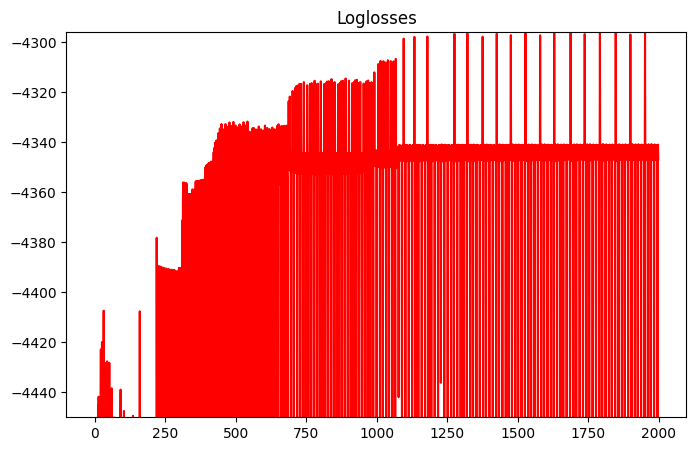

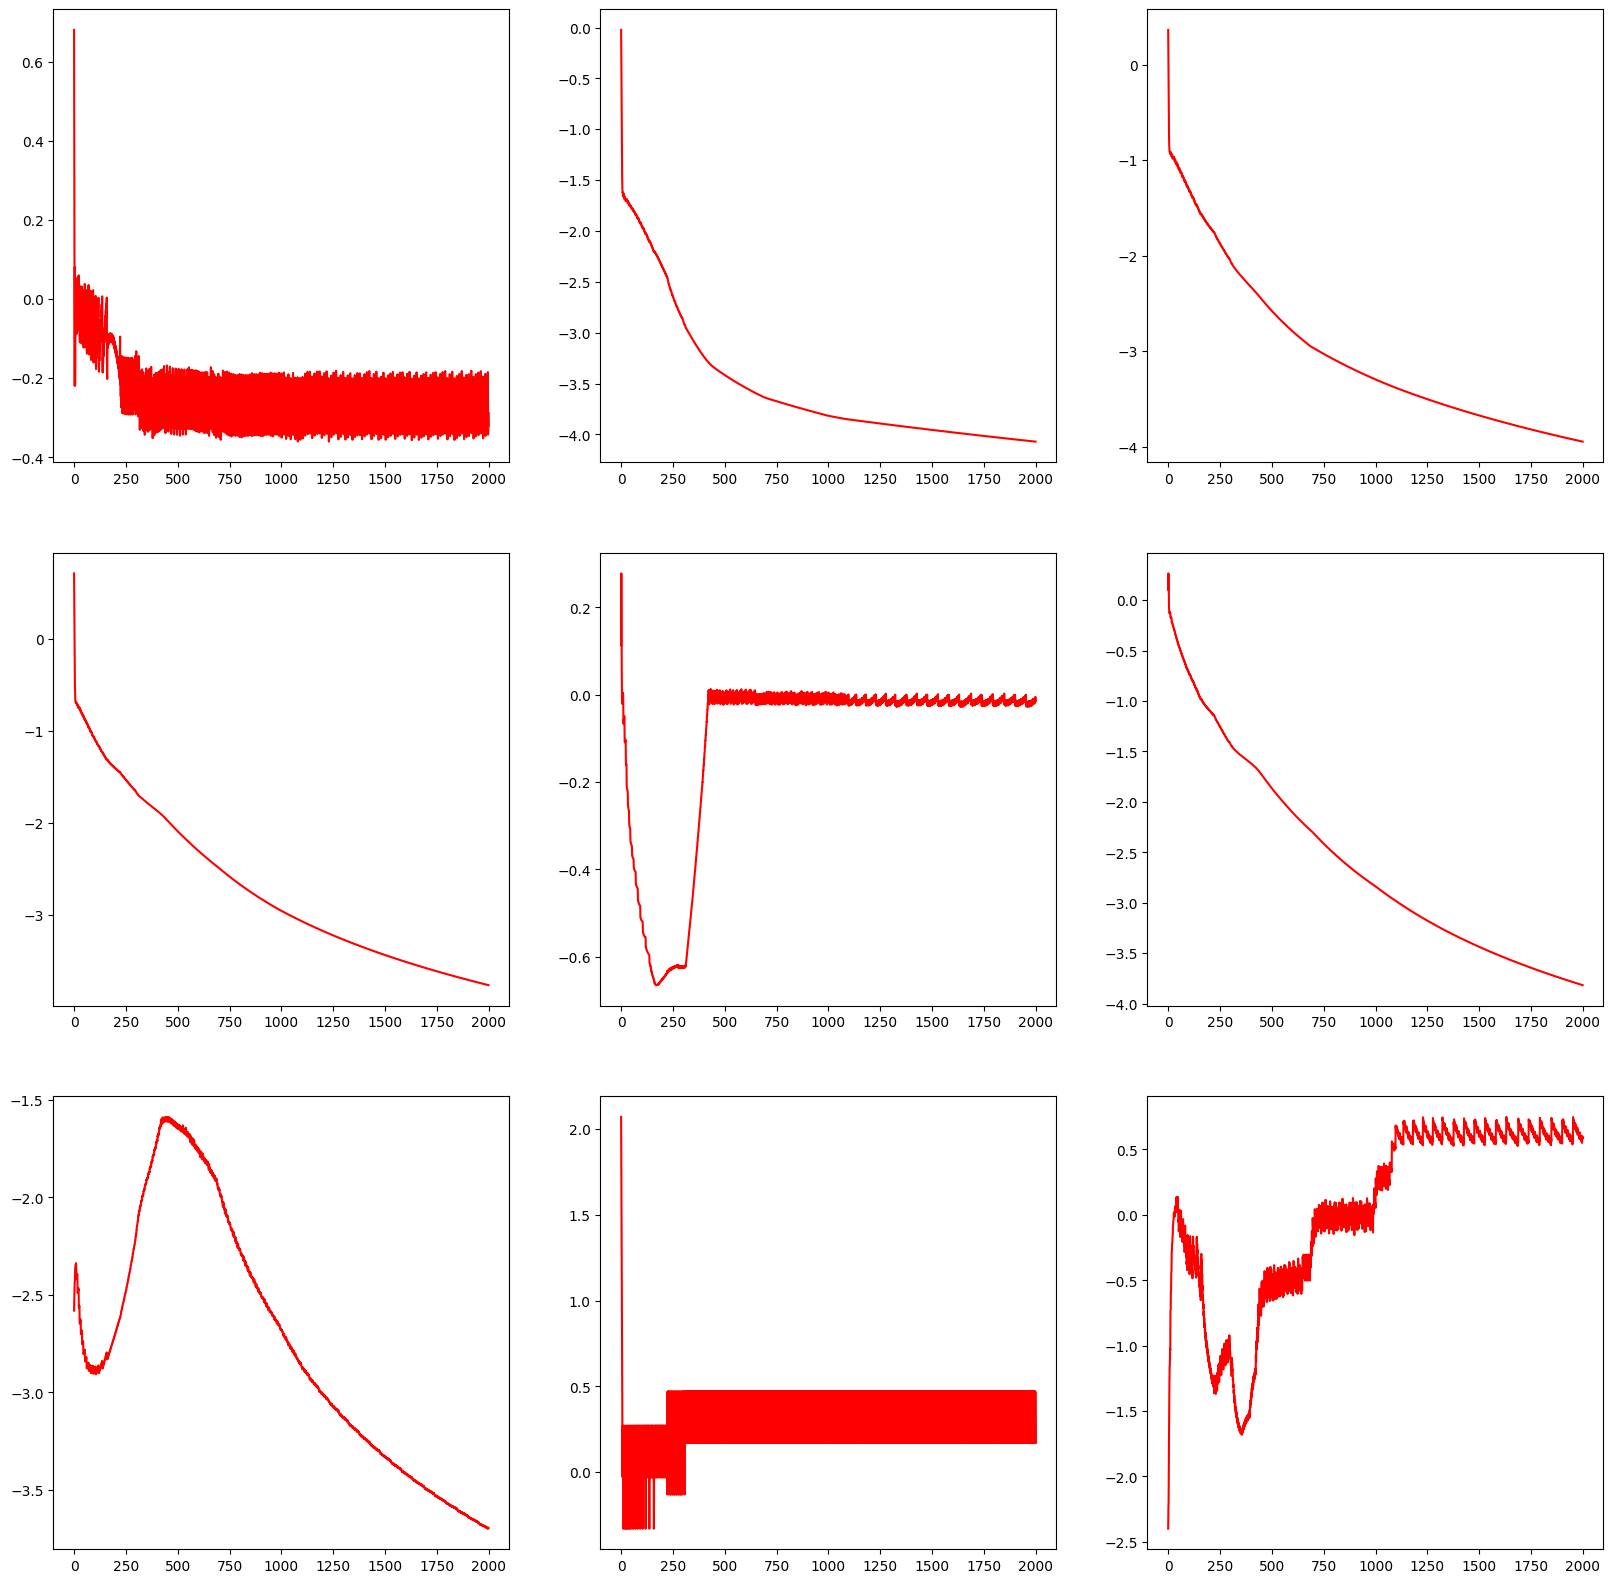

initial beta (Array(0.3431368, dtype=float32), Array(-0.3639171, dtype=float32), Array(-2.783917, dtype=float32), Array(1.2441087, dtype=float32), Array(-1.3094373, dtype=float32), Array(-2.7261865, dtype=float32), Array(2.959194, dtype=float32), Array(-0.03241897, dtype=float32), Array(2.4324718, dtype=float32))
-4465.812 0 (Array(0.3431368, dtype=float32), Array(-0.3639171, dtype=float32), Array(-2.783917, dtype=float32), Array(1.2441087, dtype=float32), Array(-1.3094373, dtype=float32), Array(-2.7261865, dtype=float32), Array(2.959194, dtype=float32), Array(-0.03241897, dtype=float32), Array(2.4324718, dtype=float32))
-4461.6953 2 (Array(0.0574964, dtype=float32), Array(-0.3078139, dtype=float32), Array(-2.7856932, dtype=float32), Array(1.204689, dtype=float32), Array(-1.3268024, dtype=float32), Array(-2.7286153, dtype=float32), Array(2.5947623, dtype=float32), Array(-0.03241897, dtype=float32), Array(2.6049857, dtype=float32))
-4459.5273 12 (Array(-0.56516725, dtype=float32), Array

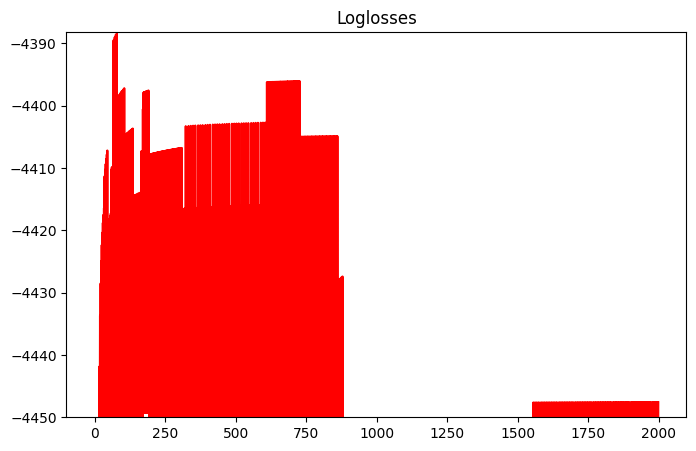

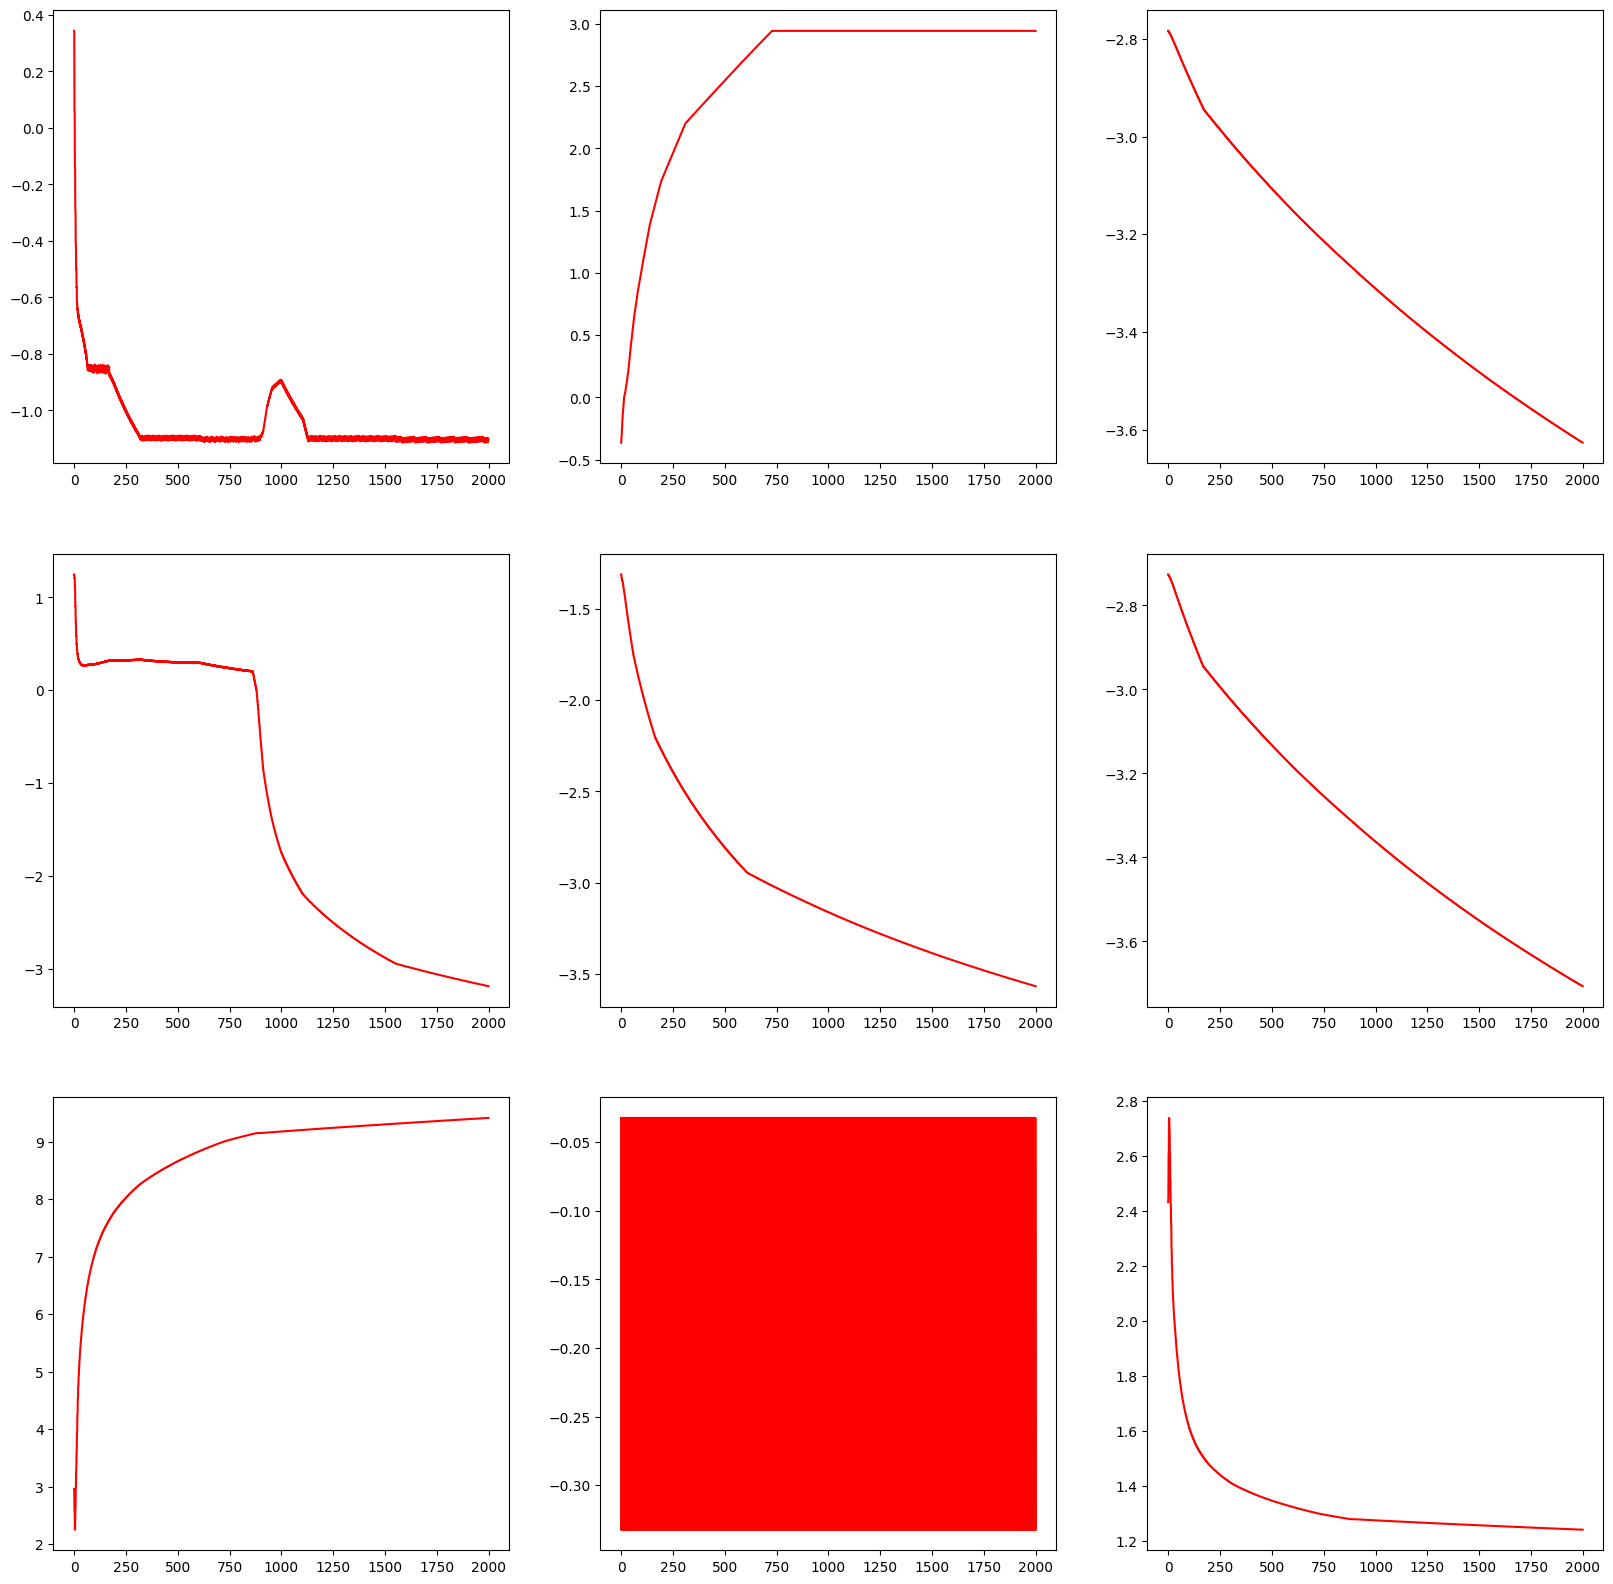

initial beta (Array(-2.4653428, dtype=float32), Array(1.2571664, dtype=float32), Array(-1.6577811, dtype=float32), Array(0.20708442, dtype=float32), Array(-2.7425451, dtype=float32), Array(2.3757813, dtype=float32), Array(-2.029388, dtype=float32), Array(-1.9991791, dtype=float32), Array(-2.4230433, dtype=float32))
-4883.427 5 (Array(-3.1050608, dtype=float32), Array(-0.24283367, dtype=float32), Array(-1.664954, dtype=float32), Array(-0.9203849, dtype=float32), Array(-2.726383, dtype=float32), Array(0.8757815, dtype=float32), Array(-0.5672873, dtype=float32), Array(-0.49917924, dtype=float32), Array(-1.2633643, dtype=float32))
-4480.6055 6 (Array(-3.114431, dtype=float32), Array(-0.24871182, dtype=float32), Array(-1.6671308, dtype=float32), Array(-0.95176345, dtype=float32), Array(-2.727747, dtype=float32), Array(0.57578146, dtype=float32), Array(-0.29789802, dtype=float32), Array(-0.19917923, dtype=float32), Array(-1.5633643, dtype=float32))
-4477.021 8 (Array(-3.1161044, dtype=float3

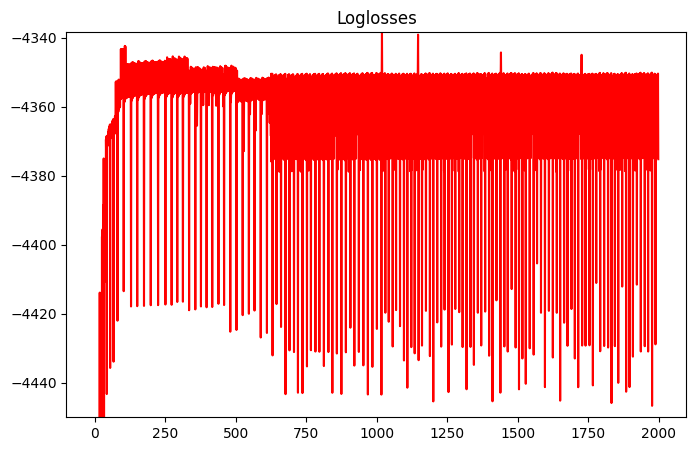

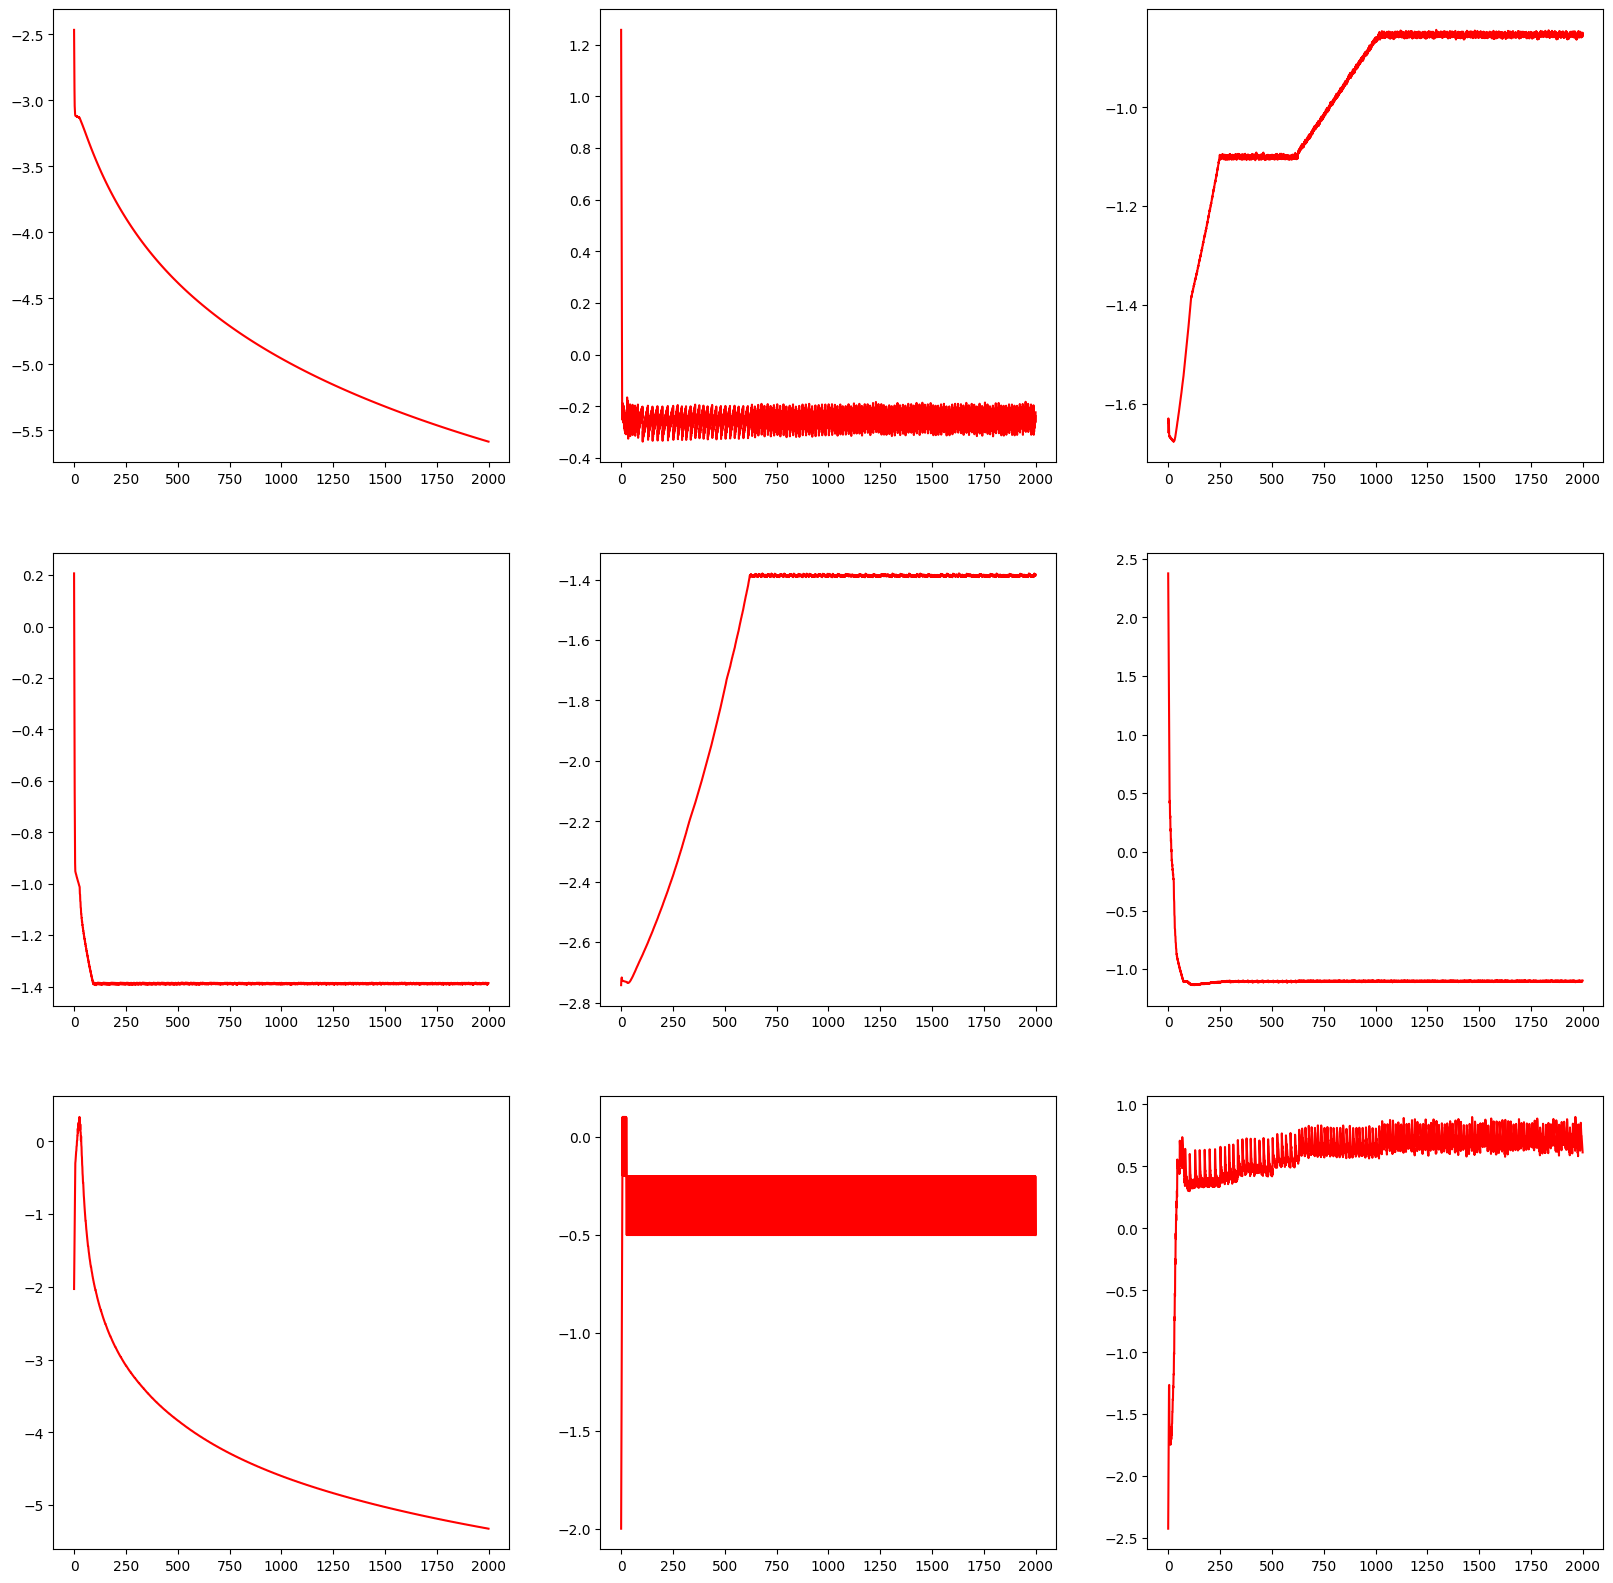

In [ ]:
import matplotlib.pyplot as plt
import jax.random as jr

key = jr.PRNGKey(42)  # Random seed
keys = jr.split(key, 10)  # Generate 10 random keys
vg = jax.value_and_grad(UK_soc_logloss, argnums=range(9))
for m in range(10):
    losses = [] 
    squares = []
    betas = []
    bests= [-5000]
    beta = tuple(jr.uniform(keys[m], shape=(9,), minval=-3, maxval=3))
    print("initial beta",beta)
    params = []
    for i in range(2000):
        l, dbeta = vg(*beta)
        if bests[-1]<l:
            bests.append(l)
            print(l,i,beta)
        else:
            bests.append(bests[-1])
        losses.append(l)
        betas.append(beta)
        beta = tuple([beta[i]+max(min(0.008*dbeta[i],0.3),-0.3) for i in range(9)])

    # Create the figure and first y-axis
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(np.arange(len(losses)), losses,label ="losses", color='r')
    
    plt.ylim(-4450, np.max(np.array(losses)))
    # print([np.round(num.item() for num in tuple(jr.uniform(keys[m], shape=(9,), minval=-3, maxval=3))])
    plt.title('Loglosses')
    plt.show()
    # Create 9 subplots in a 3x3 grid
    fig, axes = plt.subplots(nrows=3, ncols=3,figsize = (20,20))

    # Example: Plot random data in each subplot
    for i in range(3):
        for j in range(3):
            axes[i,j].plot(np.arange(len(losses)), [betas[k][3*i+j] for k in range(len(betas))],label ="losses", color='r')
    plt.show()

In [208]:
pip install optax

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 16.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


initial beta (Array(0.18156481, dtype=float32), Array(-1.1198273, dtype=float32), Array(2.4091816, dtype=float32), Array(1.1899974, dtype=float32), Array(0.7083936, dtype=float32), Array(0.73111224, dtype=float32), Array(1.3064804, dtype=float32), Array(-1.7417994, dtype=float32), Array(-2.8596718, dtype=float32))
-4472.5107 38 (Array(3.454585, dtype=float32), Array(6.5951996, dtype=float32), Array(3.001484, dtype=float32), Array(4.624024, dtype=float32), Array(3.1258996, dtype=float32), Array(4.0685534, dtype=float32), Array(1.6557093, dtype=float32), Array(-9.894934, dtype=float32), Array(-2.9700108, dtype=float32))


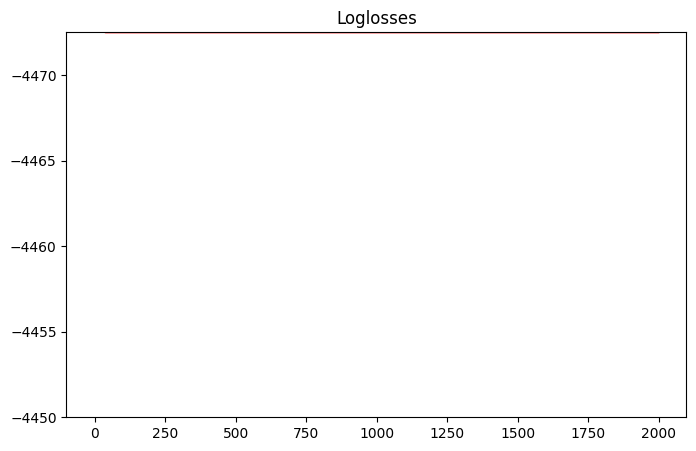

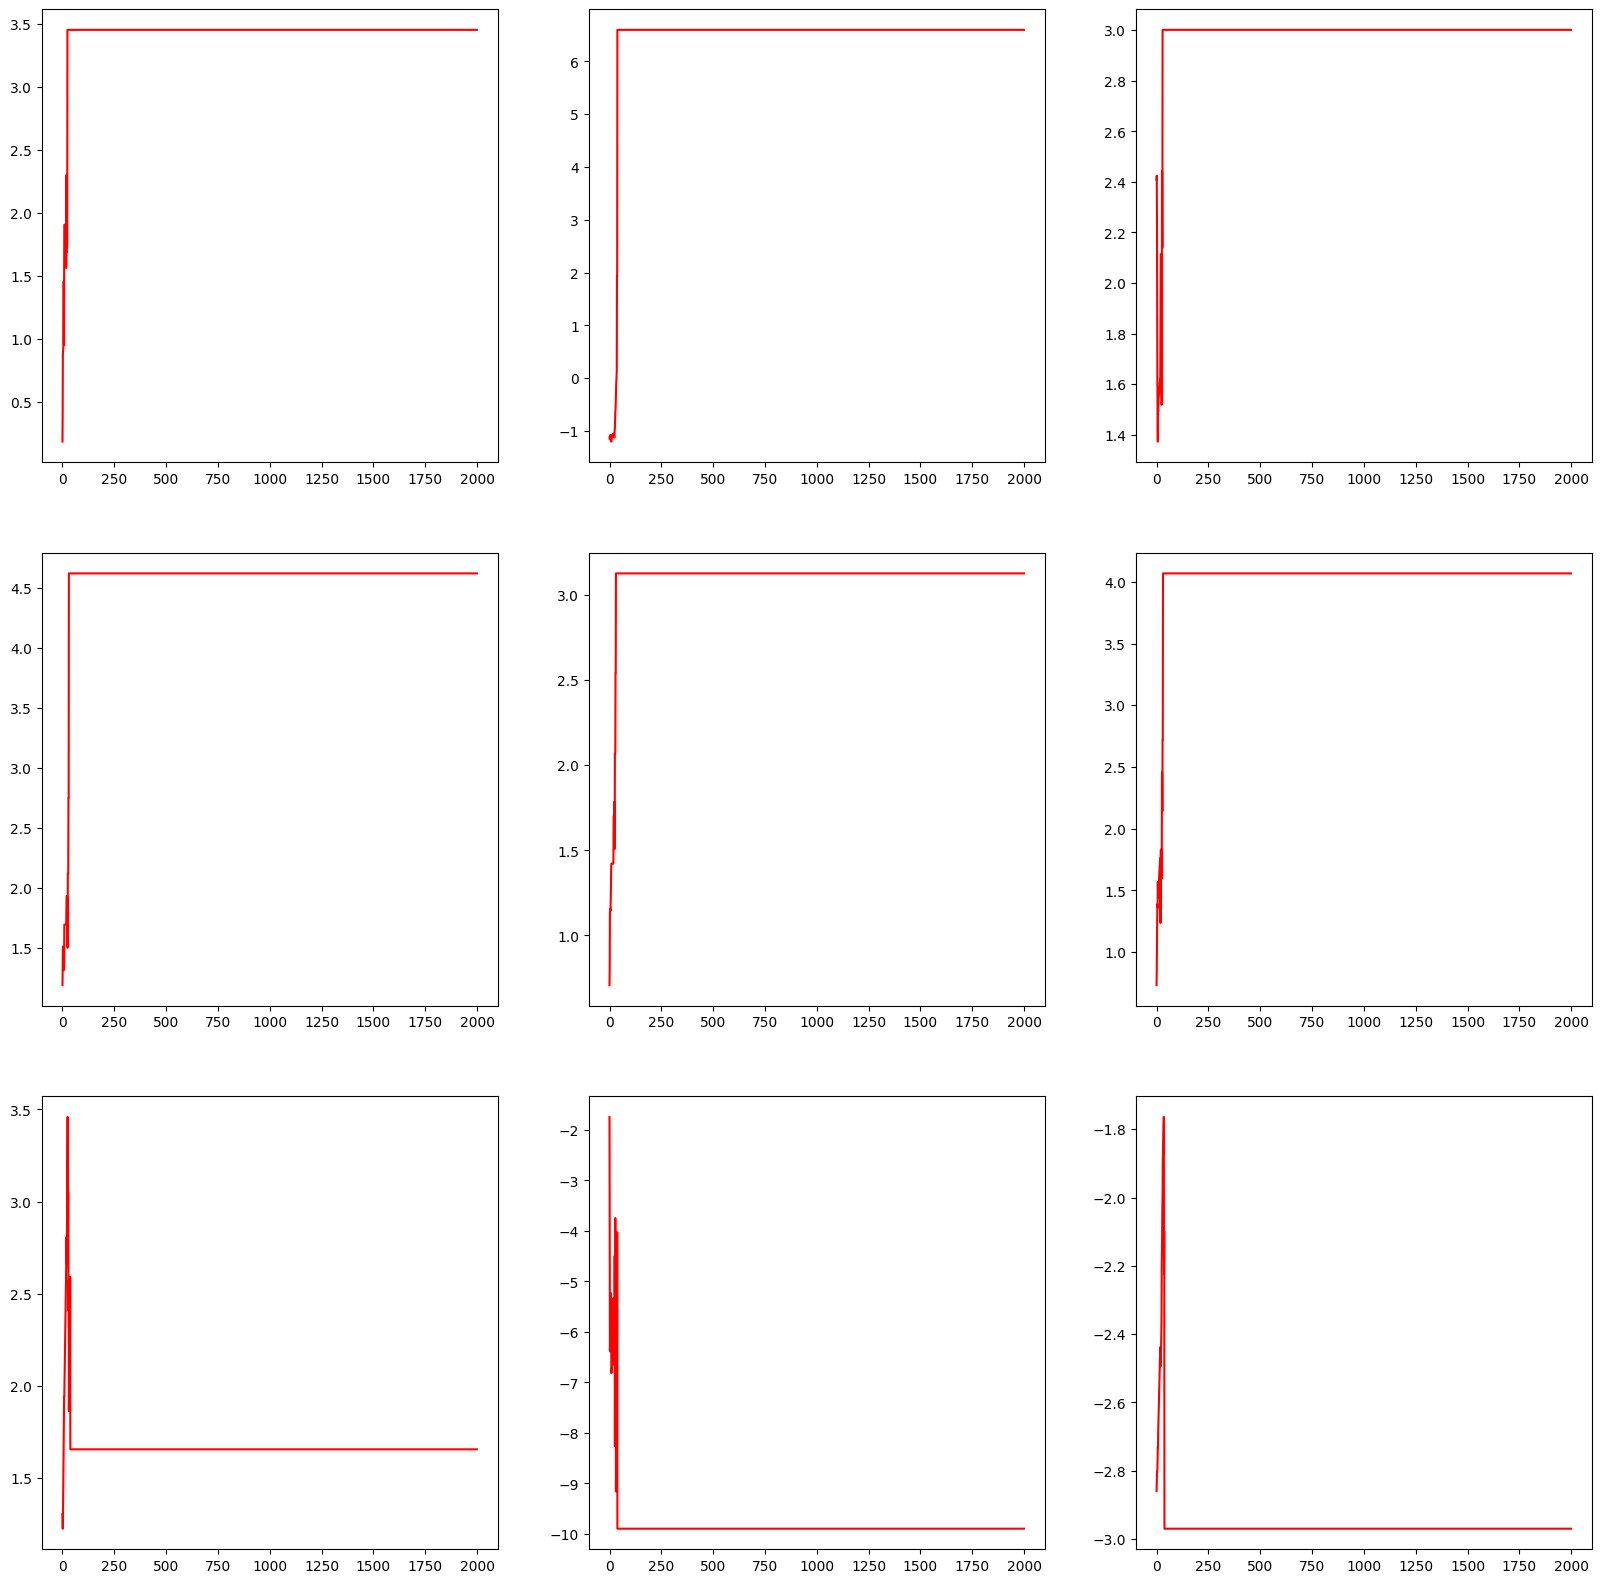

In [215]:
import matplotlib.pyplot as plt
import jax.random as jr
import optax

# Initialize optimizer (SGD)
optimizer = optax.sgd(learning_rate=0.001)

key = jr.PRNGKey(42)  # Random seed
keys = jr.split(key, 10)  # Generate 10 random keys
vg = jax.value_and_grad(UK_soc_logloss, argnums=range(9))
losses = [] 
squares = []
betas = []
bests= [-5000]
beta = tuple(jr.uniform(keys[0], shape=(9,), minval=-3, maxval=3))
opt_state = optimizer.init(beta)
print("initial beta",beta)
params = []
for i in range(2000):
    l, dbeta = vg(*beta)
    if bests[-1]<l:
        bests.append(l)
        print(l,i,beta)
    else:
        bests.append(bests[-1])
    losses.append(l)
    betas.append(beta)
    updates,opt_state = optimizer.update(dbeta, opt_state)
    beta = optax.apply_updates(beta, updates)  # Update weights

# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(np.arange(len(losses)), losses,label ="losses", color='r')

plt.ylim(-4450, np.max(np.array(losses)))
# print([np.round(num.item() for num in tuple(jr.uniform(keys[m], shape=(9,), minval=-3, maxval=3))])
plt.title('Loglosses')
plt.show()
# Create 9 subplots in a 3x3 grid
fig, axes = plt.subplots(nrows=3, ncols=3,figsize = (20,20))
# Example: Plot random data in each subplot
for i in range(3):
    for j in range(3):
        axes[i,j].plot(np.arange(len(losses)), [betas[k][3*i+j] for k in range(len(betas))],label ="losses", color='r')
plt.show()

In [ ]:
print(beta[i].item() for i in range(9))

{-0.3015386760234833, -0.20159941911697388, 0.388641893863678, -1.1350760459899902, -2.1453895568847656, -1.385132908821106, -3.4760072231292725, -2.628223419189453, -1.3893301486968994}


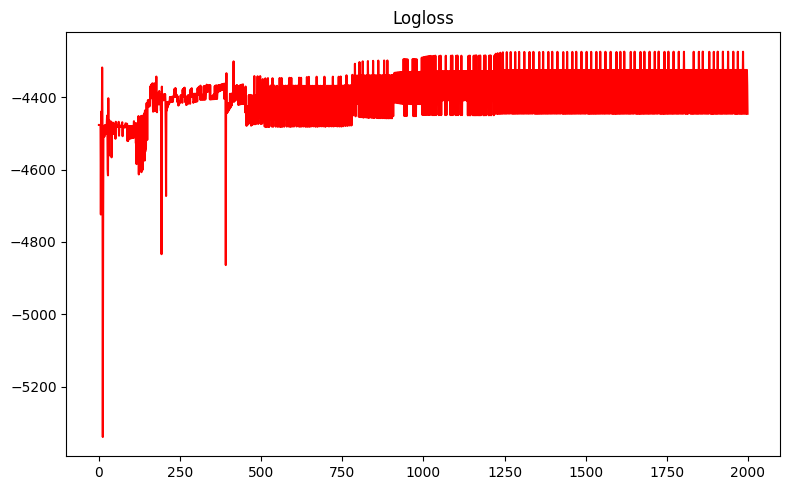

In [ ]:
# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(8, 5))



ax1.plot(np.arange(len(losses2)), losses2,label ="losses", color='r')
# ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
# # Plot the second function on ax2
# ax2.plot(np.arange(len(losses2)), squares2, label="squares", color='g')
# # plt.ylabel('MSE (%)')
# plt.xlabel('Step #')
# plt.yticks([0, 0.02], [0, 2])
plt.title('Logloss')

plt.tight_layout()

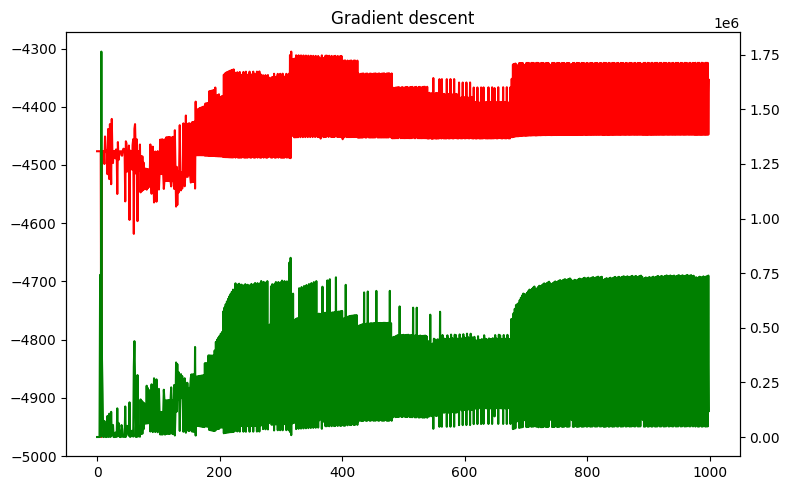

In [ ]:
# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(8, 5))



ax1.plot(np.arange(len(losses2)), losses2,label ="losses", color='r')
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
# Plot the second function on ax2
ax2.plot(np.arange(len(losses2)), squares2, label="squares", color='g')
# plt.ylabel('MSE (%)')
# plt.xlabel('Step #')
# plt.yticks([0, 0.02], [0, 2])
plt.title('Gradient descent')

plt.tight_layout()

In [ ]:
print(losses[7170:8000])
for i in range(7170,8000):
    if losses[i]>-4350:
        print(i,betas[i])
    if squares[i]>100000:
        print('squares',i,betas[i]-betas[i+1])

[Array(-4339.0107, dtype=float32), Array(-4344.3896, dtype=float32), Array(-4338.984, dtype=float32), Array(-4641.6904, dtype=float32), Array(-4575.879, dtype=float32), Array(-4547.465, dtype=float32), Array(-4504.992, dtype=float32), Array(-4479.5137, dtype=float32), Array(-4463.9326, dtype=float32), Array(-4454.218, dtype=float32), Array(-4448.051, dtype=float32), Array(-4449.808, dtype=float32), Array(-4471.1885, dtype=float32), Array(-4470.797, dtype=float32), Array(-4470.519, dtype=float32), Array(-4487.3604, dtype=float32), Array(-4587.383, dtype=float32), Array(-4478.803, dtype=float32), Array(-4477.888, dtype=float32), Array(-4477.323, dtype=float32), Array(-4476.974, dtype=float32), Array(-4476.7573, dtype=float32), Array(-4476.6226, dtype=float32), Array(-4476.539, dtype=float32), Array(-4476.4863, dtype=float32), Array(-4476.453, dtype=float32), Array(-4476.432, dtype=float32), Array(-4476.42, dtype=float32), Array(-4476.4116, dtype=float32), Array(-4476.4062, dtype=float32)

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

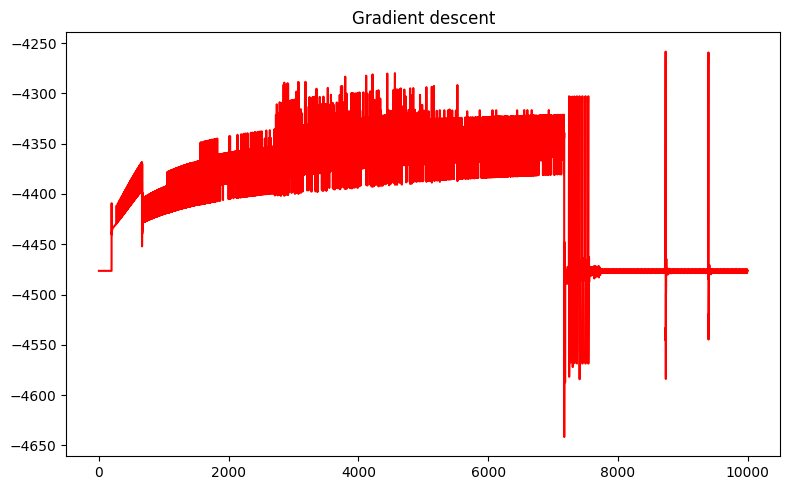

In [ ]:
# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(8, 5))



ax1.plot(np.arange(len(losses)), losses,label ="losses", color='r')
# ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
# Plot the second function on ax2
# ax2.plot(np.arange(len(losses)), squares, label="squares", color='g')
# plt.ylabel('MSE (%)')
# plt.xlabel('Step #')
# plt.yticks([0, 0.02], [0, 2])
plt.title('Gradient descent')

plt.tight_layout()

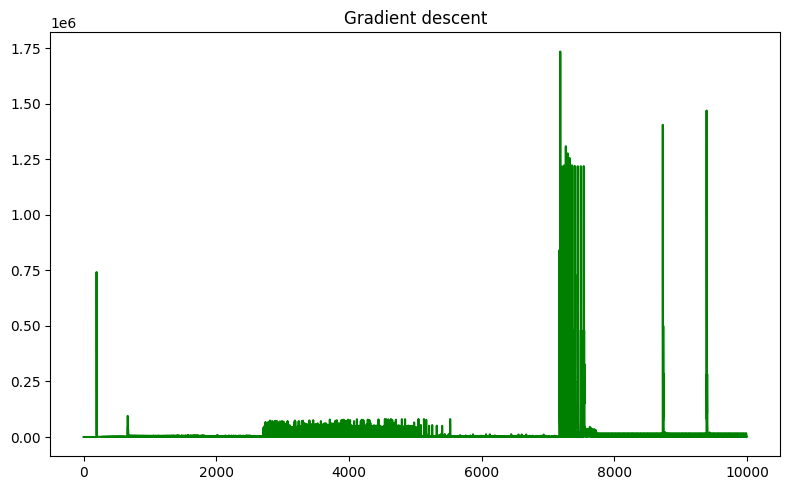

In [ ]:
# Create the figure and first y-axis
fig, ax2 = plt.subplots(figsize=(8, 5))



# ax1.plot(np.arange(len(losses)), losses,label ="losses", color='r')
# ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
# # Plot the second function on ax2
ax2.plot(np.arange(len(losses)), squares, label="squares", color='g')
# plt.ylabel('MSE (%)')
# plt.xlabel('Step #')
# plt.yticks([0, 0.02], [0, 2])
plt.title('Gradient descent')

plt.tight_layout()

In [ ]:
# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(8, 5))



ax1.plot(np.arange(len(losses)), losses,label ="losses", color='r')
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
# Plot the second function on ax2
ax2.plot(np.arange(len(losses)), [betas[i][1].item() for i in range(losses)], label="slightly thresholds", color='g')
# plt.ylabel('MSE (%)')
# plt.xlabel('Step #')
# plt.yticks([0, 0.02], [0, 2])
plt.title('Gradient descent')

plt.tight_layout()

In [ ]:
UK_soc_logloss(*betas[665])
# print(UK_soc_logloss(0.053903620690107346, 0.20066224038600922, 0.015887431800365448, -0.00021214743901509792, -0.1499279886484146, -0.10944078862667084, -0.7810240387916565, -0.3434985876083374, 1.082831859588623))
# print(UK_soc_logloss(0.053903620690107346, 0.20066224038600922, 0.015887431800365448, -0.00021214743901509792, -0.1499279886484146, -0.10944078862667084, -0.7810240387916565, -0.3434985876083374, 1.0851609706878662))
# print(UK_soc_logloss(0.053903620690107346, 0.20066224038600922, 0.015887431800365448, -0.00021214743901509792, -0.1499279886484146, -0.10944078862667084, -0.7834803462028503, -0.3434985876083374, 1.0851609706878662))
# print(UK_soc_logloss(0.053903620690107346, 0.20066224038600922, 0.015887431800365448, 0.00041755905840545893, -0.1499279886484146, -0.10944078862667084, -0.7834803462028503, -0.3434985876083374, 1.0851609706878662))
# print(UK_soc_logloss(0.053903620690107346, 0.20066224038600922, 0.015887431800365448, 0.00041755905840545893, -0.1499279886484146, -0.10944078862667084, -0.7834803462028503, -0.3434985876083374, 1.0851609706878662))
# for i in range(9):
print(UK_soc_logloss(*betas[664]))
params = list(betas[664])
params[1]=0.20068
params[3]=betas[665][3]
print(UK_soc_logloss(*tuple(params)))
params[1]=0.20067
print(UK_soc_logloss(*tuple(params)))

-4368.3926
-4452.53
-4396.295


-4476.4707 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
-5239.6836 (Array(-0.21016294, dtype=float32, weak_type=True), Array(-0.01000021, dtype=float32, weak_type=True), Array(0.0021455, dtype=float32, weak_type=True), Array(-0.00043294, dtype=float32, weak_type=True), Array(-0.06534524, dtype=float32, weak_type=True), Array(-0.05755783, dtype=float32, weak_type=True), Array(-0.06309942, dtype=float32, weak_type=True), Array(-0.6740607, dtype=float32, weak_type=True), Array(0.09051705, dtype=float32, weak_type=True))
-4476.758 (Array(-0.18233119, dtype=float32, weak_type=True), Array(-0.13607478, dtype=float32, weak_type=True), Array(-0.16095844, dtype=float32, weak_type=True), Array(-0.08855995, dtype=float32, weak_type=True), Array(-0.06216268, dtype=float32, weak_type=True), Array(-0.0621071, dtype=float32, weak_type=True), Array(0.0848781, dtype=float32, weak_type=True), Array(0.19612539, dtype=float32, weak_type=True), Array(0.10890357, dtype=float32, weak_type=True))
-4476.5513 

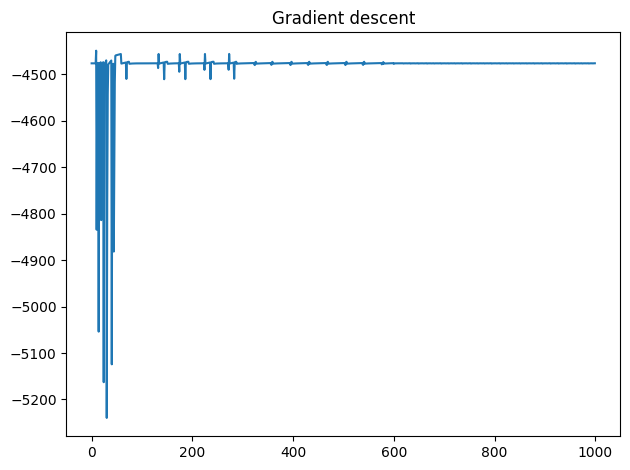

In [ ]:
import matplotlib.pyplot as plt
vg = jax.value_and_grad(UK_soc_logloss, argnums=range(9))
losses = []
beta = (0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)
params = []
for i in range(1000):
    l, dbeta = vg(*beta)
    losses.append(l)
    params.append(beta[0])
    if i%30 == 0:
        print(l,beta)
    beta = tuple([beta[i]+0.001*dbeta[i] for i in range(9)])

plt.plot(np.arange(len(losses)), losses)
# plt.ylabel('MSE (%)')
# plt.xlabel('Step #')
# plt.yticks([0, 0.02], [0, 2])
plt.title('Gradient descent')

plt.tight_layout()
# plt.savefig('../paper/fig/rsa-fit.pdf')

In [ ]:
# sum rows of UK_measured_values which are same mod 6
import numpy as np
# plot histogram of arr
import matplotlib.pyplot as plt
for i in range(6):
    plt.plot(state_values,np.sum(US_measured_values[i::6],axis=0), marker = 'o',color='r', label="US")
    plt.plot(state_values,np.sum(UK_measured_values[i::6],axis=0), marker = 'o',color='b', label="UK")
    plt.legend()
    plt.xlabel('z-score threshold')
    plt.ylabel('count for dialogue scenario')
    plt.show()


NameError: name 'state_values' is not defined

Produce graph from ideal parameters

Experimenting

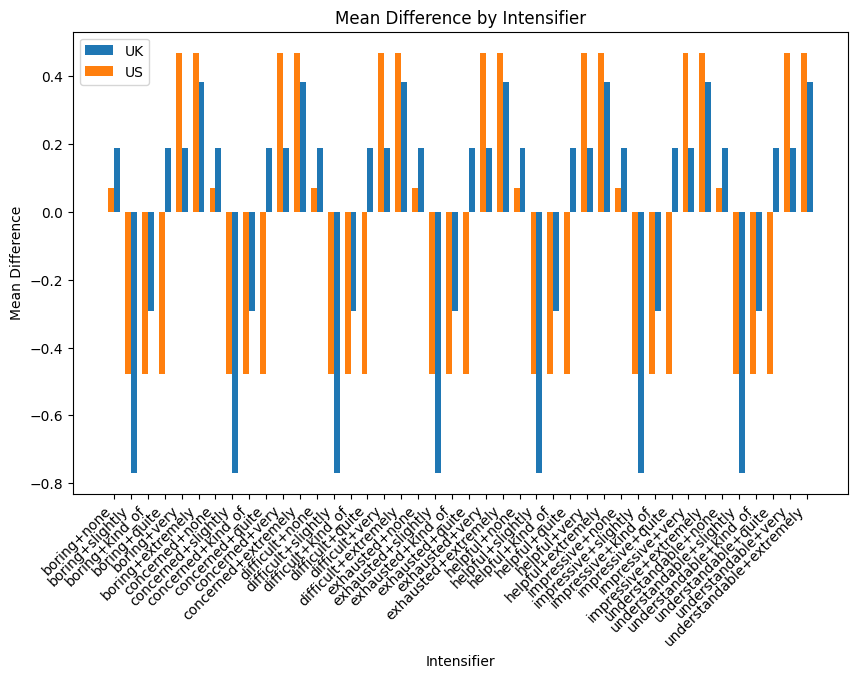

In [ ]:
# for utterence in W:
#     print(U_soc_key_map[utterence])
#     # Compute weighted mean
#     weighted_mean = np.average(state_values, weights=P_l1[:,utterence])

#     # Compute weighted variance
#     variance = np.average((state_values - weighted_mean) ** 2, weights=P_l1[:,utterence])
#     # Compute weighted standard deviation
#     std_dev = np.sqrt(variance)
# plot values next to eachother of each of values in new_US[('difference','mean')].keys()
# so x lables are new_US[('difference','mean')].keys() which are predicate intensifier pairs
# y values are new_US[('difference','mean')].values() and new_UK[('difference','mean')].values()
import matplotlib.pyplot as plt
# US_soc_logloss(7,19,5,7,7,12,0,0.5,0)
cost = 0
inf_term = 0.6
soc_term = 0
thetas = [8,18,18,18,12,12] # these should be integers
USL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],p=p) 
P_l1 = np.concat([USL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],p=p) for p in P],axis=1)# note this should be P(s|w)
us_means = [np.average(state_values, weights=P_l1[:,u]) for u in range(len(P_l1[0]))]
us_std = [np.average((state_values - us_means[u]) ** 2, weights=P_l1[:,u]) for u in range(len(P_l1[0]))]
us_var = [us_std[u]**0.5 for u in W]

# specify ideal parameters for UK (coarser search)
thetas = [8,0,6,8,8,10] # these should be integers
cost = 1.8
inf_term = 0.6
soc_term = 0
# this is for UK version
P_l1 = np.concat([UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],p=p) for p in P],axis=1)# note this should be P(s|w)
uk_means = [np.average(state_values, weights=P_l1[:,u]) for u in range(len(P_l1[0]))]
uk_std = [np.average((state_values - uk_means[u]) ** 2, weights=P_l1[:,u]) for u in range(len(P_l1[0]))]
uk_var = [uk_std[u]**0.5 for u in W]
# Plotting
# convert range(48) to np array
x = np.array(range(42))  # X positions for bars
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
bars_uk = ax.bar(x + width/2, uk_means, width, label='UK')
bars_us = ax.bar(x - width/2, us_means, width, label='US')

# # Add error bars
# ax.errorbar(x - width/2, us_means, us_std, fmt='none', ecolor='black', capsize=2)
# ax.errorbar(x + width/2, uk_means, uk_std, fmt='none', ecolor='black', capsize=2)
# remove the numbers on bar

# Add labels, title, and legend
ax.set_xlabel('Intensifier')
ax.set_ylabel('Mean Difference')
ax.set_title('Mean Difference by Intensifier')
ax.set_xticks(x)
ax.set_xticklabels([f'{p.name}+{utterence.name}' for p in P for utterence in W] , rotation=45, ha='right')
ax.legend()
plt.show()


In [ ]:
uk_distr = np.sum(np.array([P_l1[:,u] for u in range(0,42,6)]),axis = 0)
print(uk_distr)


7.0
